## Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
import seaborn as sns
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import matplotlib.gridspec as gridspec
from itertools import chain
import math
import h5py
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from cooltools.lib.numutils import set_diag
import itertools
from cooltools.lib import peaks
from matplotlib_venn import venn3, venn3_circles
from scipy.stats import pearsonr, spearmanr
from scipy.stats import mannwhitneyu

## Many RNA-DNA interactions occurs in trans: Fig. 1 & Fig. S1-2 

### Fig. 1A: The proportion of trans-interactions for RNAs of different types

In [2]:
plot_dir = '/pollard/data/HiC/Plots'
data_dir = '/pollard/home/skuang/3D_Genome_Prediction/Akita/specific_map/github/Data'
nascent = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_iMARGI_nofilter1K_genelevel_TPM',sep='\t',header=0)
trans = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_iMARGI_filter1M_genelevel_TPM',sep='\t',header=0).rename(columns={'Count': 'Count_Trans', 'iMARGI_TPM': 'iMARGI_TPM_Trans'})
combined_full = nascent.merge(trans,how='left',on=['GeneID','Ensembl_ID','GeneName','GeneType','GeneLoc','Start','End','Length'])
combined_full['Count_Trans'] = combined_full['Count_Trans'].fillna(0)
combined = combined_full[combined_full['Count']>5]
combined['Count_Cis'] = combined['Count'] - combined['Count_Trans']
combined['CisRatio'] = combined['Count_Cis']/combined['Count']
combined['TransRatio'] = combined['Count_Trans']/combined['Count']

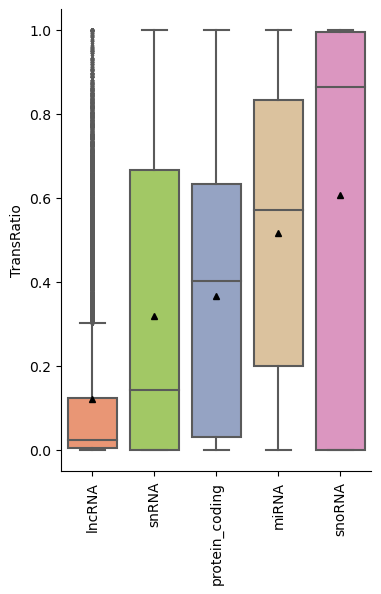

In [3]:
RNA_type_list = ['lncRNA','snRNA','snoRNA','protein_coding','miRNA']
multiRNAs = combined[combined['GeneType'].isin(RNA_type_list)]

fig, ax = plt.subplots(figsize=(4, 6))
RNA_order = ['lncRNA','snRNA','protein_coding','miRNA','snoRNA']
palette_set2 = sns.color_palette("Set2", 8)
colors =[palette_set2[1],palette_set2[4],palette_set2[2],palette_set2[6],palette_set2[3]]

sns.boxplot(data=multiRNAs, y='TransRatio', x='GeneType',order=RNA_order,palette=colors,flierprops = dict(markersize = 2),showmeans=True, \
             meanprops={"markerfacecolor":"black", "markersize":4, "markeredgecolor":"black"},ax=ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_title("")
ax.set_xlabel("")
ax.grid(False)
#plt.savefig(f'{plot_dir}/RNAs_TransRatio.pdf')

### Fig. 1B and Supplementary Fig. 1: RNA-DNA interactions within and across compartments, SPIN states and chromHMM states

In [4]:
def get_squared_matrix(df,name_order):
    squared = pd.DataFrame(index=name_order,columns=name_order,dtype=float)
    for k,nr in enumerate(name_order):
        value1 = df.loc[nr].values[0]
        for v,nr2 in enumerate(name_order):
            value2 = df.loc[nr2].values[0]
            squared.iloc[k,v] = value1 * value2
    return squared

In [5]:
def get_normalized_count(count_file,col_order,size_mat):
    stats_df = pd.read_table(count_file,header=None,names=['State1','State2','Count'])
    stats_mat = stats_df.pivot_table(columns='State1', index='State2', values='Count').reindex(col_order)
    stats_mat = stats_mat[col_order]
    stats_mat_norm = stats_mat/size_mat
    return stats_mat_norm

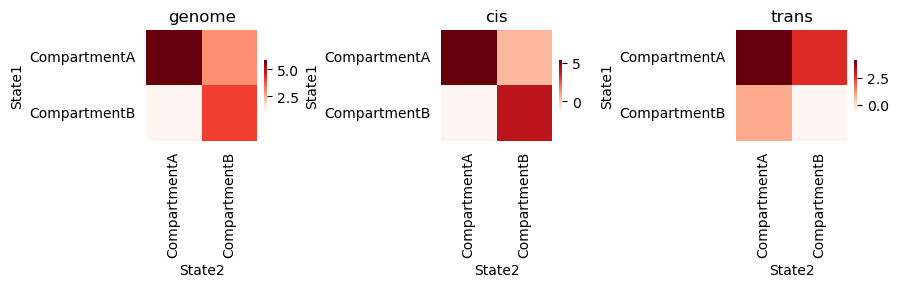

In [6]:
compartment_order = ['CompartmentA','CompartmentB']
SPIN_order = ['Speckle', 'Interior_Act1', 'Interior_Act2', 'Interior_Act3', 'Interior_Repr1', 'Interior_Repr2', 'Near_Lm1', 'Near_Lm2', 'Lamina']
chromHMM_order=['U1_TssA','U2_TssFlnk','U3_TssFlnkU', 'U4_TssFlnkD', 'U5_Tx', 'U6_EnhG1', 'U7_EnhG2', 'U8_EnhG3', 'U9_EnhG4', 'U10_EnhA1', 'U11_EnhA2', 'U12_EnhWk', 'U13_ZNF/Rpts', 'U14_Het', 'U15_TssBiv', 'U16_EnhBiv', 'U17_ReprPC', 'U18_Quies']

compartment_size = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_compartment_size',header=0,index_col=0,sep='\t')/1000000
SPIN_size = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_SPIN_state_size',header=0,index_col=0,sep='\t')/1000000
chromHMM_size = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_chromHMM_state_size',header=0,index_col=0,sep='\t')/1000000

compartment_size_mat = get_squared_matrix(compartment_size,compartment_order)
SPIN_size_mat = get_squared_matrix(SPIN_size,SPIN_order)
chromHMM_size_mat = get_squared_matrix(chromHMM_size,chromHMM_order)

fig, ax = plt.subplots(1,3,figsize=(9, 3))

for (i,reg) in zip(range(3),['genome','cis','trans']):
    compartment_file = f'{data_dir}/Data_exploration/HFFc6_compartment_RNA_DNA_{reg}_interactions'
    compartment_mat = get_normalized_count(compartment_file,compartment_order,compartment_size_mat)
    _ = sns.heatmap(np.log2(compartment_mat.T), square=True,cmap='Reds',ax=ax[i],cbar_kws={"shrink": 0.3})
    _.tick_params(bottom=False,left=False)
    ax[i].set_title(reg)
    
plt.tight_layout()
#plt.savefig(f'{plot_dir}/RNA_DNA_interactions_across_Compartments.pdf')

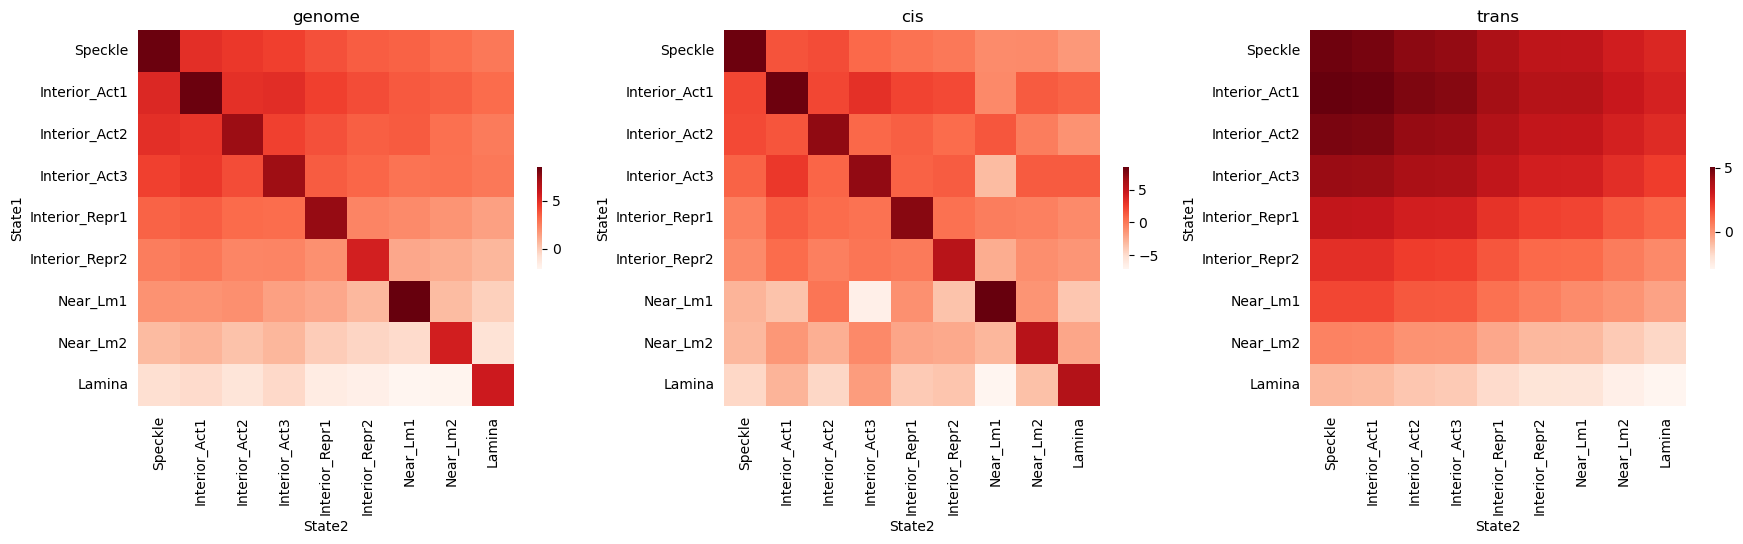

In [7]:
fig, ax = plt.subplots(1,3,figsize=(18, 6))
for (i,reg) in zip(range(3),['genome','cis','trans']):
    SPIN_file = f'{data_dir}/Data_exploration/HFFc6_SPIN_RNA_DNA_{reg}_interactions'
    SPIN_mat = get_normalized_count(SPIN_file,SPIN_order,SPIN_size_mat)
    _ = sns.heatmap(np.log2(SPIN_mat.T), square=True,cmap='Reds',ax=ax[i],cbar_kws={"shrink": 0.2})
    _.tick_params(bottom=False,left=False)
    ax[i].set_title(reg)
    
plt.tight_layout()
#plt.savefig(f'{plot_dir}/RNA_DNA_interactions_across_SPIN_States.pdf')


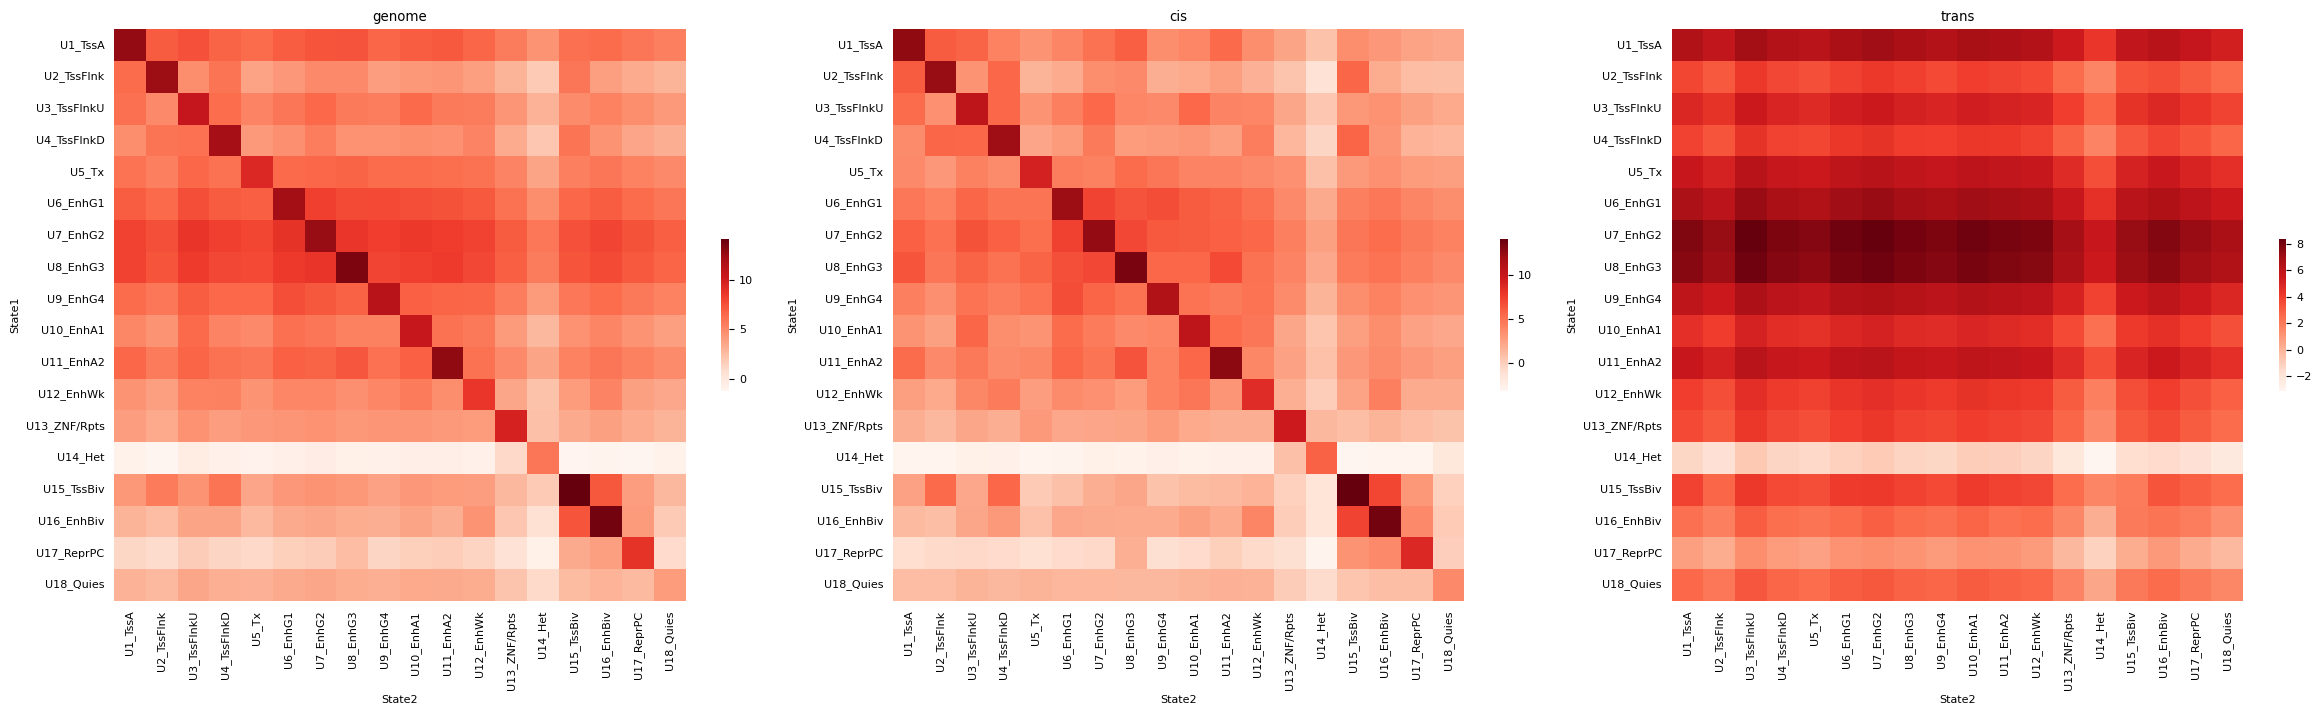

In [8]:
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(1,3,figsize=(24, 8))
for (i,reg) in zip(range(3),['genome','cis','trans']):
    chromHMM_file = f'{data_dir}/Data_exploration/HFFc6_chromHMM_RNA_DNA_{reg}_interactions'
    chromHMM_mat = get_normalized_count(chromHMM_file,chromHMM_order,chromHMM_size_mat)
    _ = sns.heatmap(np.log2(chromHMM_mat.T), square=True,cmap='Reds',ax=ax[i],cbar_kws={"shrink": 0.2})
    _.tick_params(bottom=False,left=False)
    ax[i].set_title(reg)
    
plt.tight_layout()
#plt.savefig(f'{plot_dir}/RNA_DNA_interactions_across_ChromHMM_States.pdf')

### Fig. 1D: The percentage of genome-wide cis-interactions and trans-interactions

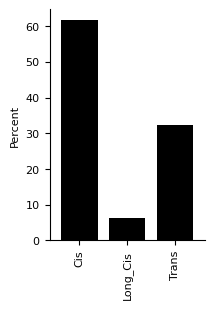

In [9]:
Inter_ratio_data = [['Cis', 61.62],['Long_Cis', 6.14],['Trans', 32.24]]
Inter_ratio_df = pd.DataFrame(Inter_ratio_data, columns=['Type', 'Ratio'])

fig, ax = plt.subplots(figsize=(2,3))
Inter_ratio_df.plot(x='Type',kind='bar',stacked=False,color= 'black',width=0.76,ax=ax).legend(bbox_to_anchor=(1.0, 1.0),fontsize=8)
ax.set_ylabel('Percent')
ax.set_xlabel('')
ax.get_legend().remove()
#plt.savefig(f'{plot_dir}/HFF_Cis_Trans_Inter_Distribution.pdf')

### Fig. 1E: RNA-DNA interaction frequencies aginst genomic distance

<Axes: xlabel='Distance', ylabel='Count'>

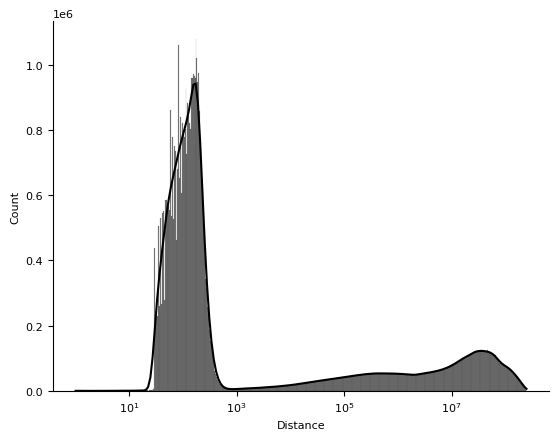

In [10]:
RNA_DNA_distance = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_RNAgene_DNA_distance.txt.gz',header=None,sep='\t',names=['EnsemblID','GeneType','Distance'])
RNA_DNA_distance_cis = RNA_DNA_distance[(RNA_DNA_distance['Distance']<250000000) & (RNA_DNA_distance['Distance']>0)]
sns.histplot(data=RNA_DNA_distance_cis,x="Distance", kde=True,
             bins=500,color = 'black', 
             log_scale=True)
#plt.savefig(f'{plot_dir}/HFFc6_RNA_DNA_Distance_Cis_Density_Plot_LogScale.pdf')

### Supplementary Fig. 2: RNA-chromatin interactions prevalently occur in trans

In [11]:
cis_ratio = []
trans_ratio = []
RNA_df = {}
RNA_cis_df = {}
RNA_trans_df = {}
for rt in RNA_order:
    RNA_df[rt] = RNA_DNA_distance[RNA_DNA_distance['GeneType']==rt]
    RNA_cis_df[rt] = RNA_DNA_distance[(RNA_DNA_distance['GeneType']==rt) & (RNA_DNA_distance['Distance']<250000000)]
    RNA_trans_df[rt] = RNA_DNA_distance[(RNA_DNA_distance['GeneType']==rt) & (RNA_DNA_distance['Distance']>=250000000)]
    cis_ratio.append(RNA_cis_df[rt].shape[0]/RNA_df[rt].shape[0])
    trans_ratio.append(RNA_trans_df[rt].shape[0]/RNA_df[rt].shape[0])

Text(0, 0.5, 'Percent')

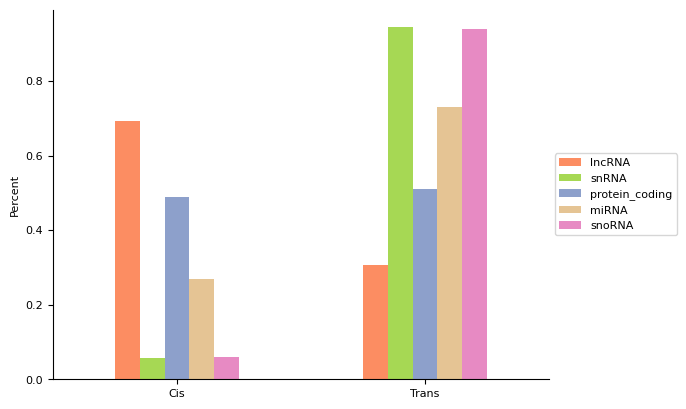

In [12]:
ratio_df = pd.DataFrame({'Cis':cis_ratio,'Trans':trans_ratio})
ratio_df = ratio_df.set_index(pd.Series(RNA_order))

my_colors=[palette_set2[1],palette_set2[4],palette_set2[2],palette_set2[6],palette_set2[3]]
ax = ratio_df.T.plot(kind='bar', color=my_colors)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.tick_params(axis='both')
ax.set_xlabel("")
ax.set_ylabel("Percent")
#plt.savefig(f'{plot_dir}/RNATypes_Cis_Trans_Ratio.pdf')

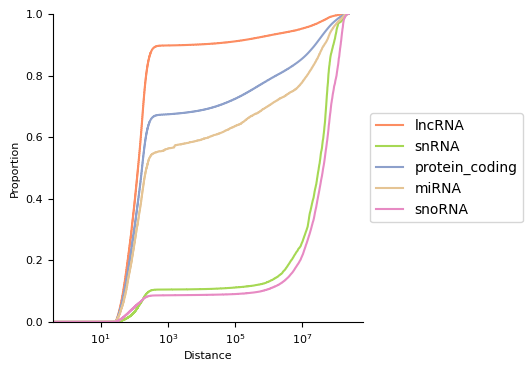

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
for (rt,color) in zip(RNA_order,colors):
    sns.ecdfplot(data=RNA_cis_df[rt], x="Distance",label=rt,ax=ax,color=color)
ax.legend(prop={'size': 10},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
#plt.savefig(f'{plot_dir}/RNATypes_Cis_RNA_DNA_Interactions_Distance_CDF.pdf')

## Trans-located caRNAs are particularly enriched at TAD boundaries: Fig. 2

### Fig. 2A: TAD boundaries in A and B compartments

In [14]:
HFF_TAD_annos = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_TAD_detailed_annos',header=0,sep='\t')
HFF_TAD = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_TAD_anno_category',header=0,sep='\t')
HFF_TAD_annos_value = HFF_TAD_annos.merge(HFF_TAD,on=['chrom','start','end'])

HFF_trans = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_RNA_class_count_long_cis_trans_5000',header=0,sep='\t')
HFF_nascent = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_nascent_RNA_5000',header=0,sep='\t')
HFF_ATACseq = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_ATACseq_5000.bedgraph',header=0,sep='\t')
HFF_ATACseq.columns = ['chrom','start','end','ATACseq']

HFF_IS_annos_exp = HFF_TAD_annos_value.merge(HFF_trans,on=['chrom','start','end']).merge(HFF_nascent,on=['chrom','start','end'])

HFF_IS_annos_exp['trans_sum'] = HFF_IS_annos_exp['other_smallRNA']+HFF_IS_annos_exp['snRNA']+HFF_IS_annos_exp['snoRNA'] \
                                +HFF_IS_annos_exp['misc_RNA']+HFF_IS_annos_exp['lncRNA']+HFF_IS_annos_exp['protein_coding'] \
                                +HFF_IS_annos_exp['others']+HFF_IS_annos_exp['nogene']

HFF_IS_annos_exp['logsum'] = np.log(HFF_IS_annos_exp['sum']+1)
HFF_IS_annos_exp['logtrans_sum'] = np.log(HFF_IS_annos_exp['trans_sum']+1) 

HFF_IS_annos_exp_ATACseq = HFF_IS_annos_exp.merge(HFF_ATACseq,on=['chrom','start','end'])
HFF_IS_annos_exp_ATACseq['logatac'] = np.log(HFF_IS_annos_exp_ATACseq['ATACseq']+0.01)
HFF_IS_annos_exp_ATACseq['trans2atac'] = np.log(HFF_IS_annos_exp_ATACseq['trans_sum']/(HFF_IS_annos_exp_ATACseq['ATACseq']+0.01)+1)


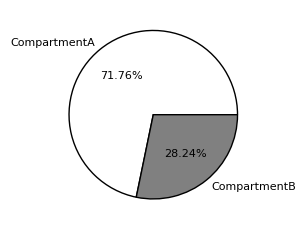

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))
HFF_TAD_annos_value[HFF_TAD_annos_value['compartment']!='-'].groupby('compartment').size().plot(kind='pie', autopct='%.2f%%',colors=['white','grey'],wedgeprops = {"edgecolor" : "black"},ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
#plt.savefig(f'{plot_dir}/HFFc6_TAD_boundaries_in_compartments.pdf')

### Fig. 2C: ATAC-seq and caRNA signals at strong versus weak TAD boundaries

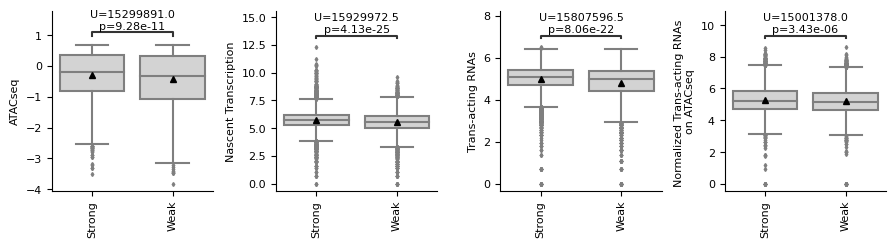

In [16]:
Cate_order = ['Strong','Weak']
RNAs = ['logatac','logsum','logtrans_sum','trans2atac']
labels = ['ATACseq','Nascent Transcription','Trans-acting RNAs','Normalized Trans-acting RNAs \non ATACseq']

fig, ax = plt.subplots(1,len(RNAs),figsize=(9,2.5))
for i in range(len(RNAs)):
    sns.boxplot(x="Level", y=RNAs[i], data=HFF_IS_annos_exp_ATACseq, \
            order=Cate_order,color='lightgrey',flierprops = dict(markersize = 2),showmeans=True, \
             meanprops={"markerfacecolor":"black", "markersize":4, "markeredgecolor":"black"},ax=ax[i])
    U,p = mannwhitneyu(HFF_IS_annos_exp_ATACseq[HFF_IS_annos_exp_ATACseq['Level']=='Strong'][RNAs[i]].values, 
                           HFF_IS_annos_exp_ATACseq[HFF_IS_annos_exp_ATACseq['Level']=='Weak'][RNAs[i]].values)
    add_stat_annotation(ax[i], data=HFF_IS_annos_exp_ATACseq, x="Level", y=RNAs[i], order=Cate_order,
                    box_pairs=[("Strong","Weak")],text_annot_custom=[f"U={U}\np={p:.2e}"],
                    test='Mann-Whitney', loc='inside', verbose=0)
    ax[i].set_xlabel("")
    ax[i].set_ylabel(labels[i])
    for tick in ax[i].get_xticklabels():
            tick.set_rotation(90)

plt.tight_layout()
#plt.savefig(f'{plot_dir}/RNAs_ATACseq_at_TAD_boundaries.pdf')

## CaRNAs contribute to accurate prediction of 3D genome folding: Fig. 3 & Fig. S4-6

### Fig. 3B: Model performance on test set (barplot)

In [17]:
model_performance_df = pd.read_table(f'{data_dir}/Best_models/Model_performance/combined_model_performance.txt',sep='\t',header=0)
model_order = ['Seq+Random','Seq','Seq+Steady_State_RNA','Seq+Nascent_RNA','Seq+Trans-located_RNA','Seq+ATAC-seq','Seq+ATAC-seq+Trans-located_RNA']
comp_pairs = []
for i in range(len(model_order)):
    for j in range(i+1,len(model_order)):
        comp_pairs.append((model_order[i],model_order[j]))
        
non_sig_pairs_dict = {}
selected_metrics_list = model_performance_df['MetricType'].unique()
for selected_metrics in selected_metrics_list:
    non_sig = []
    model_performance_df_selected = model_performance_df[model_performance_df['MetricType']==selected_metrics]
    for pair in comp_pairs:
        m_p = mannwhitneyu(model_performance_df_selected[model_performance_df_selected['Model']==pair[0]]['Value'].values, 
                           model_performance_df_selected[model_performance_df_selected['Model']==pair[1]]['Value'].values, method="exact").pvalue
        if(m_p>0.05):
            non_sig.append(pair)
    non_sig_pairs_dict[selected_metrics] = non_sig

In [18]:
def get_metric_df(file_name,column_name):
    seq_df = pd.read_table(f'{data_dir}/Best_models/Model_performance/Seq/{file_name}',header=0)
    random_df = pd.read_table(f'{data_dir}/Best_models/Model_performance/Seq+Random/{file_name}',header=0)
    rnaseq_df = pd.read_table(f'{data_dir}/Best_models/Model_performance/Seq+SteadyStateRNA/{file_name}',header=0)
    nascent_rna_df = pd.read_table(f'{data_dir}/Best_models/Model_performance/Seq+NascentRNA/{file_name}',header=0)
    trans_rna_df = pd.read_table(f'{data_dir}/Best_models/Model_performance/Seq+Trans-locatedRNA/{file_name}',header=0)
    atac_df = pd.read_table(f'{data_dir}/Best_models/Model_performance/Seq+ATAC-seq/{file_name}',header=0)
    atac_trans_rna_df = pd.read_table(f'{data_dir}/Best_models/Model_performance/Seq+ATAC-seq+Trans-locatedRNA/{file_name}',header=0)

    metric_df = pd.DataFrame({'Seq+Random':random_df[column_name], 'Seq':seq_df[column_name],
                                'Seq+Steady_State_RNA':rnaseq_df[column_name],'Seq+Nascent_RNA':nascent_rna_df[column_name],
                                'Seq+Trans-located_RNA':trans_rna_df[column_name],'Seq+ATAC-seq':atac_df[column_name],'Seq+ATAC-seq+Trans-located_RNA':atac_trans_rna_df[column_name]})
    return metric_df 

In [19]:
def barplot_vis(ax,data_df,selected_metrics,sub_pairs,model_order,model_colors,ymin,ymax):
    sns.stripplot(x="MetricType", y="Value", hue="Model", hue_order = model_order, 
            data=data_df, dodge=True,palette=model_colors,alpha=0.9,size=3,ax=ax)
    sns.barplot(x="MetricType", y="Value", hue="Model", hue_order = model_order, 
            data=data_df, estimator=np.mean, errorbar='se',
            capsize=0.03, errwidth=1.5, palette=model_colors, alpha=0.4, ax=ax)
    annotator = Annotator(ax, sub_pairs, x="MetricType", y="Value", hue="Model", hue_order = model_order, 
                data=data_df, estimator=np.mean, errorbar='se',
                capsize=0.03, errwidth=1.5, palette=model_colors,alpha=0.4,verbose=0)
    annotator.configure(test="Mann-Whitney").apply_and_annotate()
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel("")
    return ax

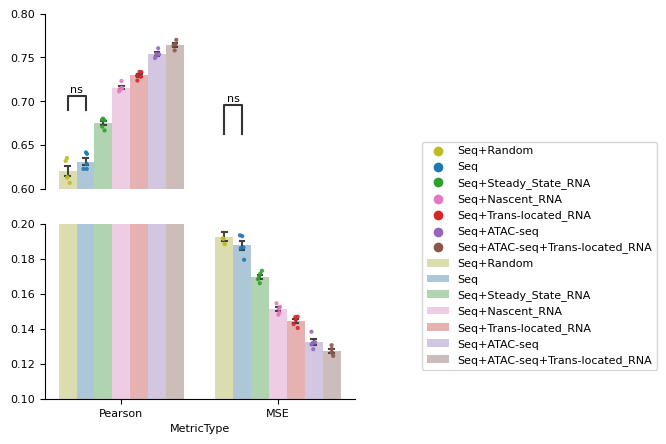

In [20]:
selected_metrics = ['Pearson','MSE']
model_performance_df_sub = model_performance_df[model_performance_df['MetricType'].isin(selected_metrics)]
pairs_combine = []
for sm in selected_metrics:
    pairs = []
    for cp in non_sig_pairs_dict[sm]:
        pairs.append([(sm,cp[0]),(sm,cp[1])])
    pairs_combine.append(pairs)

palette_tab10 = sns.color_palette("tab10", 10)
model_colors = [palette_tab10[8],palette_tab10[0],palette_tab10[2],palette_tab10[6],palette_tab10[3],palette_tab10[4],palette_tab10[5]]

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(4,5))
ax1 = barplot_vis(ax1,model_performance_df_sub,selected_metrics,pairs_combine[0],model_order,model_colors,0.6,0.8)
ax1.spines['bottom'].set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_legend().remove()

ax2 = barplot_vis(ax2,model_performance_df_sub,selected_metrics,pairs_combine[1],model_order,model_colors,0.1,0.2)
ax2.get_legend().remove()
ax2.legend(bbox_to_anchor=(1.2, 1.5),fontsize=8)

plt.show()
metric_name = '_'.join(selected_metrics)
#plt.savefig(f'{plot_dir}/HFF_test_set_performance_{metric_name}.pdf')

### Fig. 3C: Model performance on test set (Violin plot of correlation of insulation track)

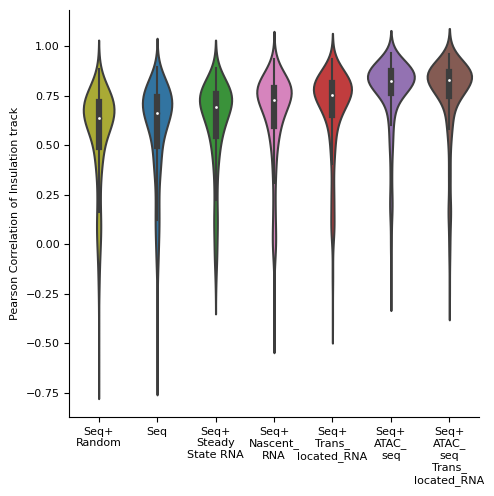

In [21]:
insulation_data = get_metric_df('test_seq_insulation_corr_HFF.txt','TAD')

fig, ax = plt.subplots(figsize=(5,5))

sns.violinplot(data=insulation_data,ax=ax,palette=model_colors)
ax.set_xticklabels(labels=["Seq+\nRandom","Seq","Seq+\nSteady\nState RNA","Seq+\nNascent_\nRNA","Seq+\nTrans_\nlocated_RNA","Seq+\nATAC_\nseq","Seq+\nATAC_\nseq\nTrans_\nlocated_RNA"], rotation=0, va="top",fontsize=8)
ax.set_ylabel('Pearson Correlation of Insulation track')

plt.tight_layout()
#plt.savefig(f'{plot_dir}/HFF_test_set_performance_insulation.pdf')

### Fig. 3D: Examples showing the predictions of models with nascent transcripts or trans-located RNAs

In [22]:
def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

def pcolormesh_45deg(ax, mat, *args, **kwargs):
    #https://stackoverflow.com/questions/12848581/is-there-a-way-to-rotate-a-matplotlib-plot-by-45-degrees
    n = mat.shape[0]
    # create rotation/scaling matrix
    t = np.array([[1,0.5],[-1,0.5]])
    # create coordinate matrix and transform it
    A = np.dot(np.array([(i[1],i[0]) for i in itertools.product(range(n,-1,-1),range(0,n+1,1))]),t)
    im = ax.pcolormesh(A[:,1].reshape(n+1,n+1),A[:,0].reshape(n+1,n+1),np.flipud(mat),*args, **kwargs)
    im.set_rasterized(True)
    ax.set_ylim(0,n)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    ax.plot([0, n/2], [0, n], 'k-',linewidth=1)
    ax.plot([n/2, n], [n, 0], 'k-',linewidth=1)        
    ax.set_aspect(.5)
    return im

def insulation_track(map, window_size=5):
    insulation_track = []
    for loc in range(0,len(map)):
        if loc <= window_size or loc >= len(map)-window_size:
            insulation_track.append(np.nan)
            continue
            
        focal_start = loc-window_size-1
        focal_end = loc+window_size+1
        
        window = map[focal_start:loc-1, loc+1:focal_end]
        window_mean = np.nanmean([np.exp(i) for i in list(chain(*window))])
        insulation_track.append(math.log2(window_mean))
    return(np.array(insulation_track))

In [23]:
preds_dict = {}
rna_inputs = {}
rna_contribution_score = {}
model_all_names = ['Seq','Seq+SteadyStateRNA','Seq+NascentRNA','Seq+Trans-locatedRNA','Seq+ATAC-seq','Seq+ATAC-seq+Trans-locatedRNA']
model_sub_names = ['Seq+SteadyStateRNA','Seq+NascentRNA','Seq+Trans-locatedRNA','Seq+ATAC-seq','Seq+ATAC-seq+Trans-locatedRNA']
rna_input_file_names = ['test_rna_inputs.h5','test_rna_inputs.h5','test_rna_inputs.h5','test_atac_inputs.h5','test_atac_rna_inputs.h5']
rna_score_file_names = ['test_rna_scores.h5','test_rna_scores.h5','test_rna_scores.h5','test_atac_scores.h5','test_atac_rna_scores.h5']

targets = h5py.File(f'{data_dir}/Best_models/Targets_predictions/Targets/HFF_test_targets.h5','r')['targets'][:,:,0]

for m_name in model_all_names:
    preds_dict[m_name] = h5py.File(f'{data_dir}/Best_models/Targets_predictions/Predictions/{m_name}/test_preds.h5','r')['preds'][:,:,0]

for (m_name,ifile,sfile) in zip(model_sub_names,rna_input_file_names,rna_score_file_names):
    rna_inputs[m_name] = h5py.File(f'{data_dir}/Best_models/Feature_inputs_and_contribution_scores/{m_name}/{ifile}',"r")['rna_inputs'][:,:,:]
    rna_contribution_score[m_name] = h5py.File(f'{data_dir}/Best_models/Feature_inputs_and_contribution_scores/{m_name}/{sfile}',"r")['rna_contrib_scores'][:,:,:]


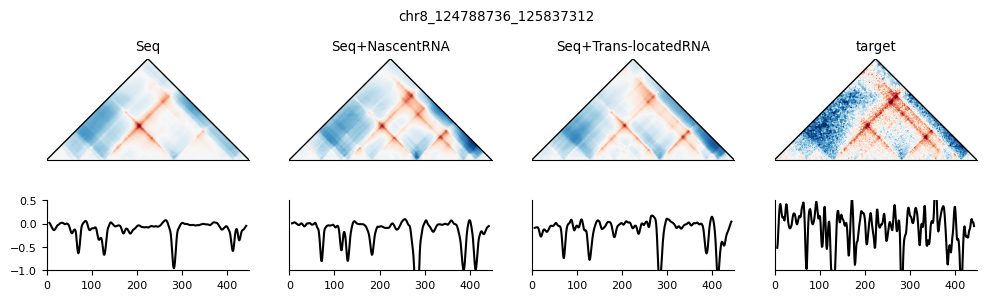

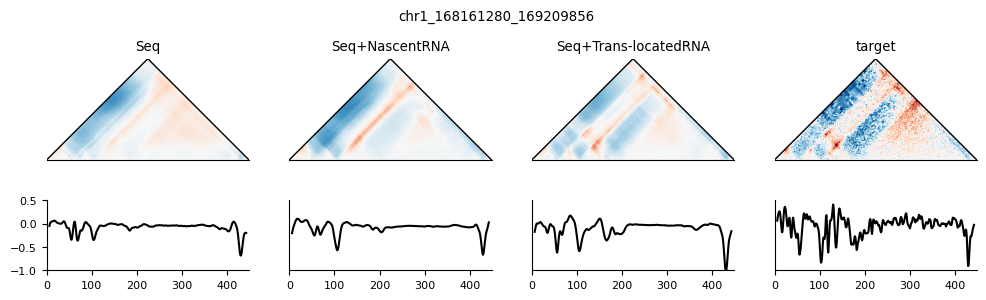

In [24]:
sequences_info = pd.read_table(f'{data_dir}/Genomic_bin_data/sequences.bed',sep="\t",header=None,names=['chrom','start','end','label'])
sequences_test = sequences_info[sequences_info['label']=='test']

indexes = [124,191]

for i in indexes:
    index_seq_info = sequences_test.iloc[i]
    index_seq_info_str = '_'.join([index_seq_info['chrom'],index_seq_info['start'].astype(str),index_seq_info['end'].astype(str)])
    fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(12,3),gridspec_kw={'height_ratios': [2,1]})
    for (mns,pi) in zip(['Seq','Seq+NascentRNA','Seq+Trans-locatedRNA'],[0,1,2]):
        pcolormesh_45deg(ax[0,pi], from_upper_triu(preds_dict[mns][i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
        ax[0,pi].set_title(mns)
        pred_insulation = insulation_track(from_upper_triu(preds_dict[mns][i,:], 448, 2),window_size=5)
        ax[1,pi].plot(pred_insulation,c='black')
        ax[1,pi].set_xlim([0,448])
        ax[1,pi].set_ylim([-1,0.5])
        if(pi>0):
            ax[1,pi].set_yticks([])
        
    pcolormesh_45deg(ax[0,3], from_upper_triu(targets[i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
    ax[0,3].set_title('target')
    target_insulation = insulation_track(from_upper_triu(targets[i,:], 448, 2),window_size=5)
    ax[1,3].plot(target_insulation,c='black')
    ax[1,3].set_xlim([0,448])
    ax[1,3].set_ylim([-1,0.5])
    ax[1,3].set_yticks([])
    fig.suptitle(index_seq_info_str)
    #plt.savefig(f'{plot_dir}/HFF_exmaple{i}.pdf')

### Supplementary Fig. 4: Model performance on the test set - additional metrics

In [25]:
###https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])
                
    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())        

In [26]:
data_metrics_SCC = get_metric_df('test_seq_metrics_scc_ssim_HFF.txt','scc')
data_metrics_MSE = get_metric_df('test_seq_metrics_scc_ssim_HFF.txt','mse')

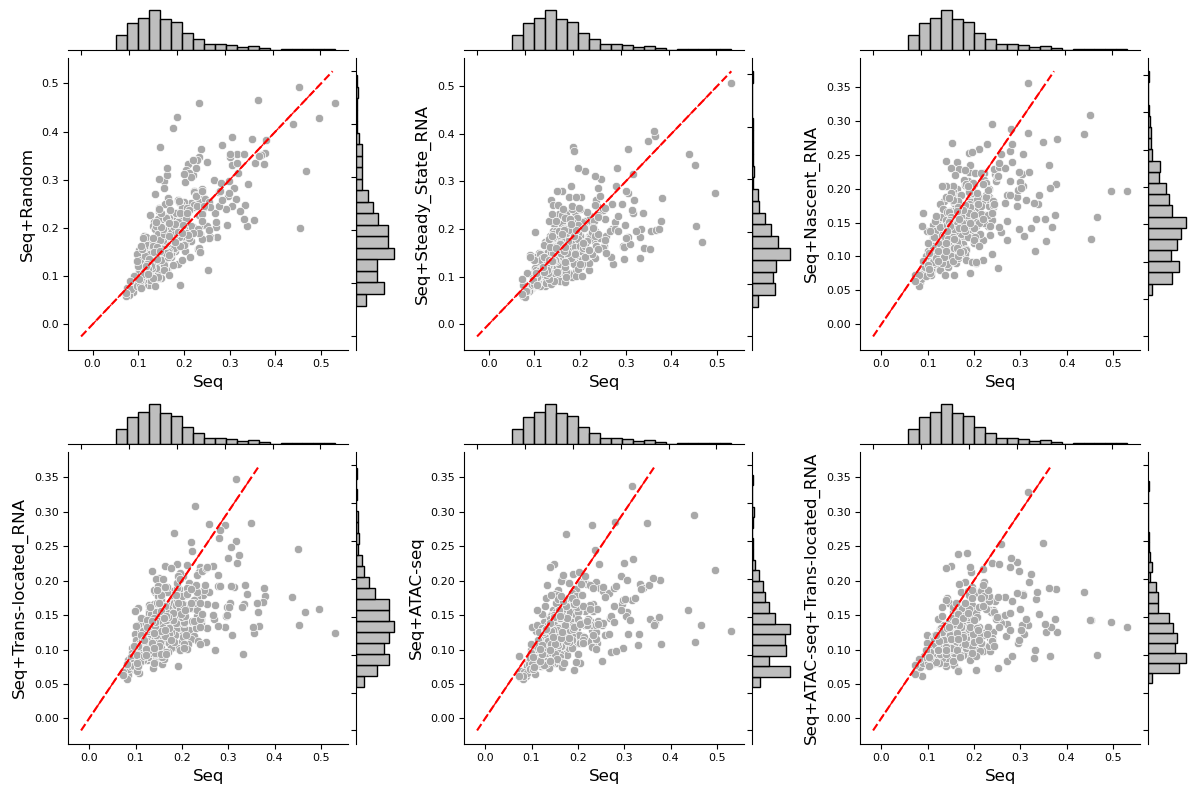

In [27]:
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 3)

model_names = ['Seq+Random','Seq+Steady_State_RNA','Seq+Nascent_RNA','Seq+Trans-located_RNA',
              'Seq+ATAC-seq','Seq+ATAC-seq+Trans-located_RNA']
axis_ranges = [[0,0.5],[0,0.5],[0,0.35],[0,0.35],[0,0.35],[0,0.35]]

for mn,gs_sub,axis_range in zip(model_names,[gs[0,0],gs[0,1],gs[0,2],gs[1,0],gs[1,1],gs[1,2]],axis_ranges):
    subfig = sns.jointplot(data=data_metrics_MSE, x="Seq", y=mn,color='darkgrey',marginal_kws=dict(bins=20))
    subfig.set_axis_labels('Seq',mn,fontsize=12)
    plt.plot(axis_range, axis_range, linestyle='--', color='red', lw=1)
    x0, x1 = subfig.ax_joint.get_xlim()
    y0, y1 = subfig.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    subfig.ax_joint.plot(lims, lims, '--r')
    _ = SeabornFig2Grid(subfig, fig,gs_sub)
    
gs.tight_layout(fig)
#plt.savefig(f'{plot_dir}/HFF_performance_mse_comparison.pdf',bbox_inches = 'tight')


Text(4.472222222222223, 0.5, 'Spearman’s Correlation')

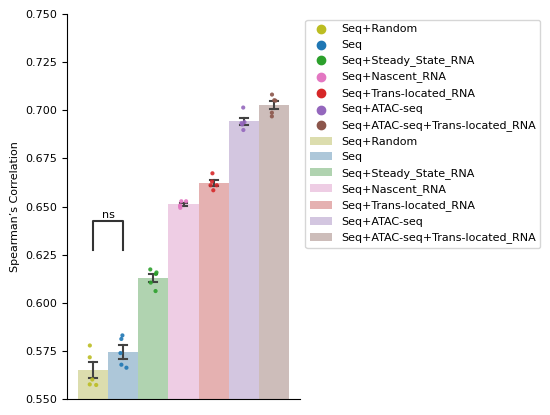

In [28]:
selected_metrics = ['Spearman']
model_performance_df_spearman_sub = model_performance_df[model_performance_df['MetricType'].isin(selected_metrics)]
pairs = []
for sm in selected_metrics:
    for cp in non_sig_pairs_dict[sm]:
        pairs.append([(sm,cp[0]),(sm,cp[1])])

fig, ax = plt.subplots(figsize=(3,5))
ax = barplot_vis(ax,model_performance_df_spearman_sub,selected_metrics,pairs,model_order,model_colors,0.55,0.75)
ax.legend(bbox_to_anchor=(1.0, 1.0),fontsize=8)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('Spearman’s Correlation')
#plt.savefig(f'{plot_dir}/HFF_combined_performance_spearman.pdf')

Text(0, 0.5, 'Stratum-adjusted Correlation Coefficient')

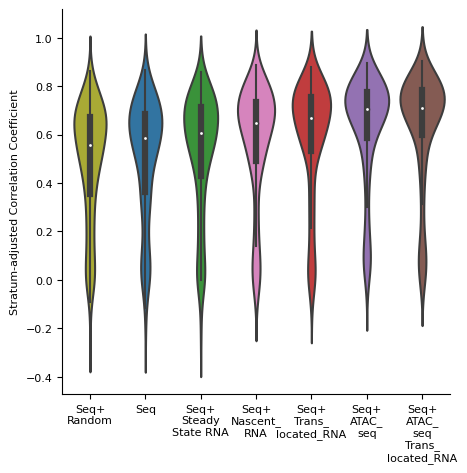

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
sns.violinplot(data=data_metrics_SCC,ax=ax,palette=model_colors)
ax.set_xticklabels(labels=["Seq+\nRandom","Seq","Seq+\nSteady\nState RNA","Seq+\nNascent_\nRNA","Seq+\nTrans_\nlocated_RNA","Seq+\nATAC_\nseq","Seq+\nATAC_\nseq\nTrans_\nlocated_RNA"], rotation=0, va="top",fontsize=8)
ax.set_ylabel('Stratum-adjusted Correlation Coefficient')
#plt.savefig(f'{plot_dir}/HFF_test_set_performance_SCC_SSIM.pdf')

### Supplementaray Fig. 5 and 6: Model inputs and contribution scores for examples in Fig. 3

In [30]:
def plot_example_1(row_index,seqs_info,pred_data,target_data,input_data,input_label):
    i = row_index
    index_seq_info = seqs_info.iloc[i]
    index_seq_info_str = '_'.join([index_seq_info['chrom'],index_seq_info['start'].astype(str),index_seq_info['end'].astype(str)])
    fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(12,12),gridspec_kw={'height_ratios': [2,1,1,1,1,1,1,1,1,1]})
    for (mns,pi) in zip(['Seq','Seq+NascentRNA','Seq+Trans-locatedRNA'],[0,1,2]):
        pcolormesh_45deg(ax[0,pi], from_upper_triu(pred_data[mns][i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
        ax[0,pi].set_title(mns)
        pred_insulation = insulation_track(from_upper_triu(pred_data[mns][i,:], 448, 2),window_size=5)
        ax[1,pi].plot(pred_insulation,c='black',linewidth=1.0)
        ax[1,pi].set_xlim([0,448])
        ax[1,pi].set_ylim([-1,0.5]) 
        
        if(mns=='Seq'):
            for j in range(2,10):
                ax[j,pi].axis('off')
        elif(mns=='Seq+NascentRNA'):
            ax[1,pi].set_xticks([])
            ax[2,pi].plot(input_data[mns][i,32:480,0],c='black',linewidth=0.5)
            ax[2,pi].set_xlim([0,448])
            for j in range(3,10):
                ax[j,pi].axis('off')
        else:
            ax[1,pi].set_xticks([])
            for (j,k) in zip(range(2,10),[1,2,0,4,5,3,6,7]):
                ax[j,pi].plot(input_data[mns][i,32:480,k],c='black',linewidth=0.5)
                ax[j,pi].set_xlim([0,448])
                if(j<9):
                    ax[j,pi].set_xticks([])
        
    pcolormesh_45deg(ax[0,3], from_upper_triu(target_data[i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
    ax[0,3].set_title('target')
    target_insulation = insulation_track(from_upper_triu(target_data[i,:], 448, 2),window_size=5)
    ax[1,3].plot(target_insulation,c='black',linewidth=1.0)
    ax[1,3].set_xlim([0,448])
    ax[1,3].set_ylim([-1,0.5])
    ax[1,3].set_yticks([])
    for j in range(2,10):
        ax[j,3].axis('off')
    fig.suptitle(index_seq_info_str)
    #plt.savefig(f'{plot_dir}/HFF_exmaple{i}_rna_{input_label}_100923.pdf')

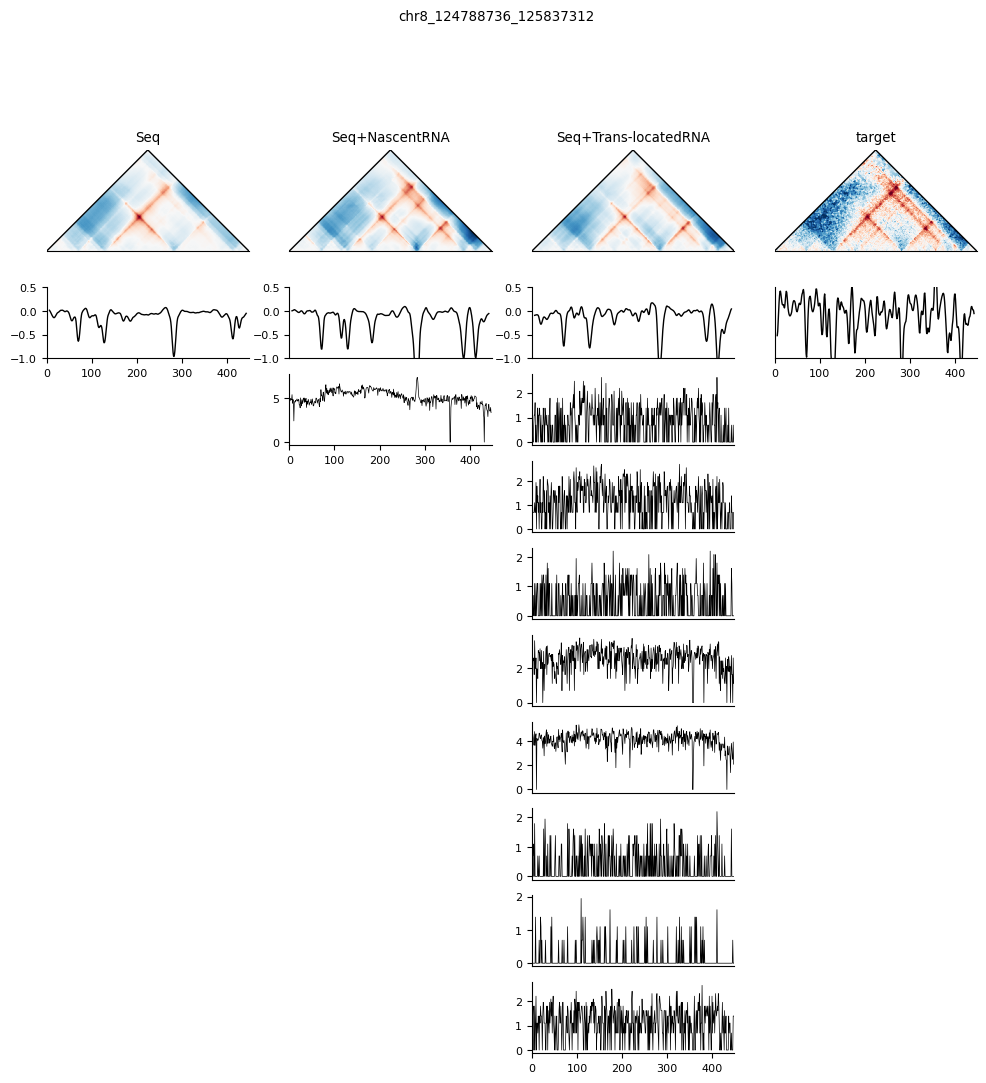

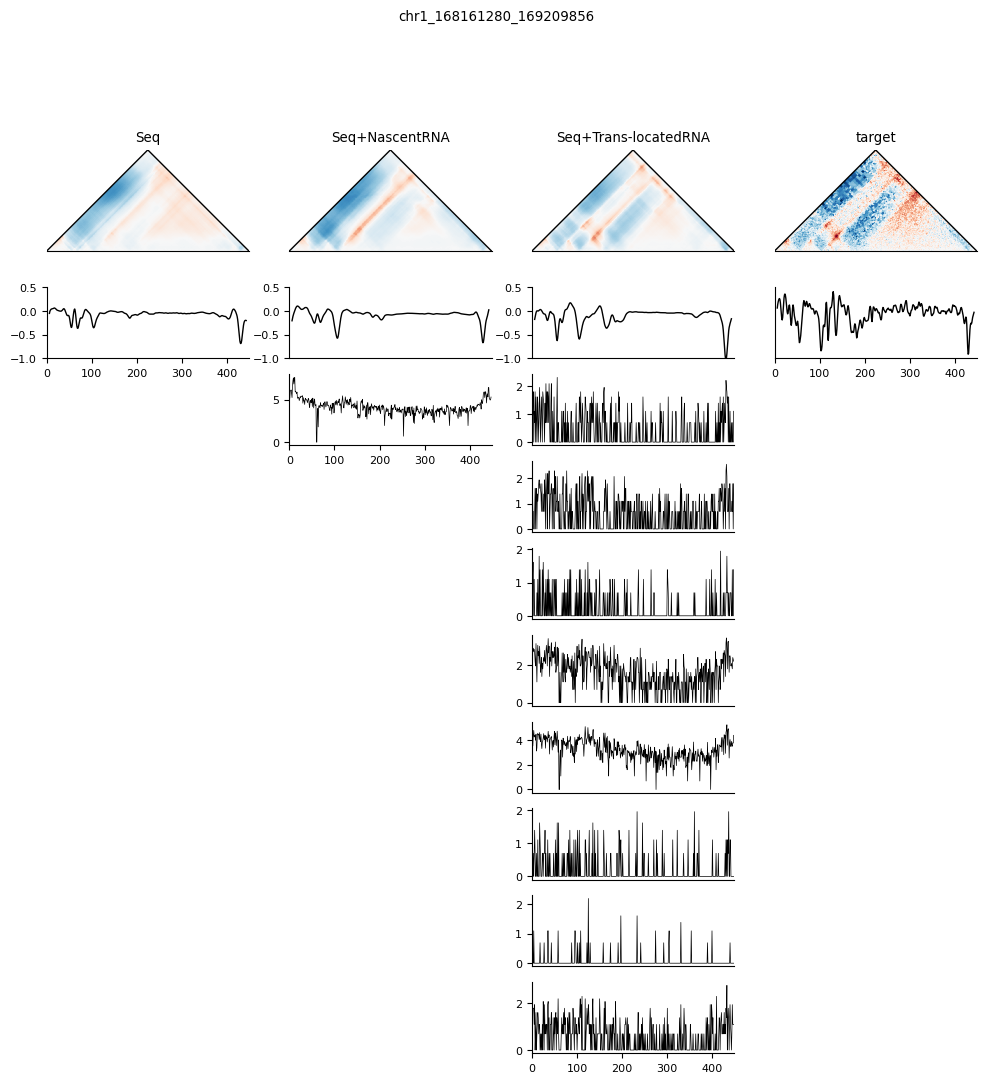

In [31]:
indexes = [124,191]

for index in indexes:
    plot_example_1(index,sequences_test,preds_dict,targets,rna_inputs,'inputs')
    

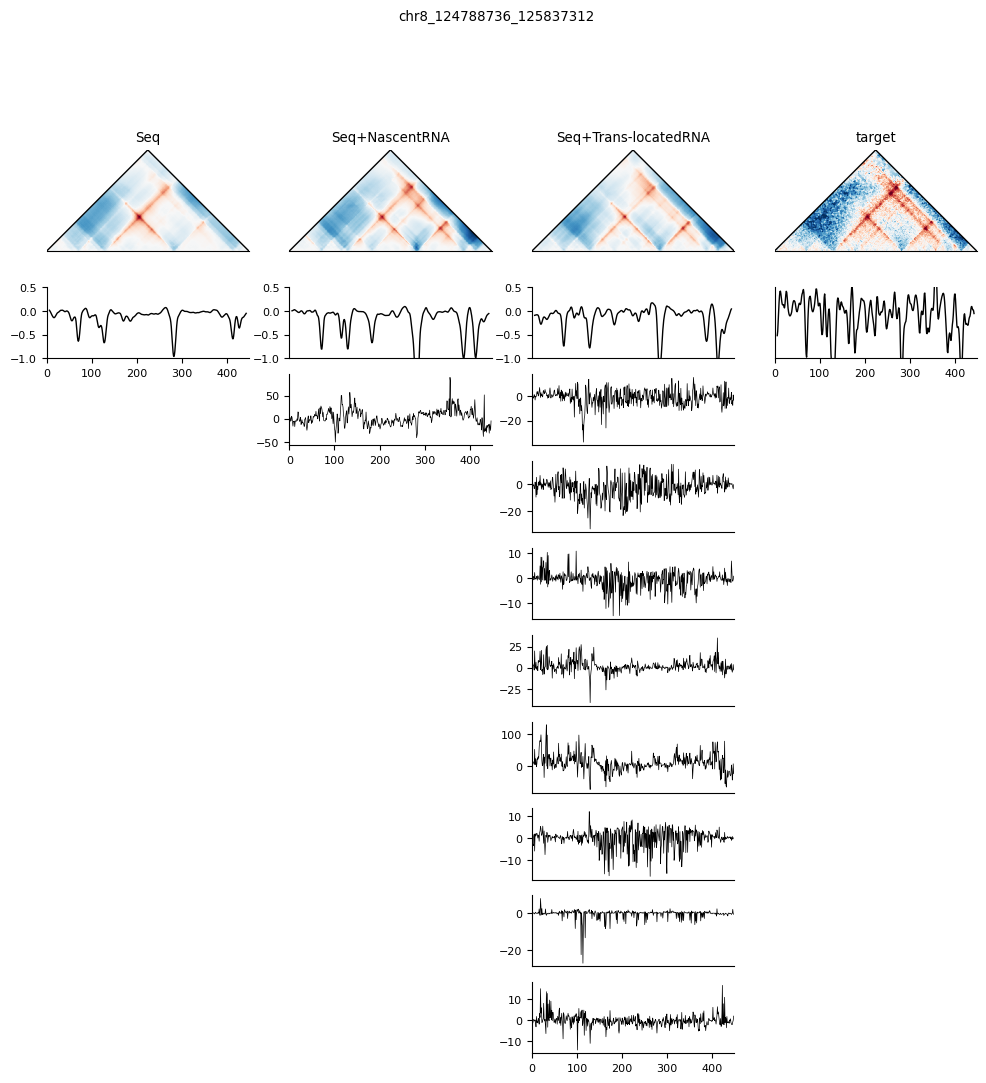

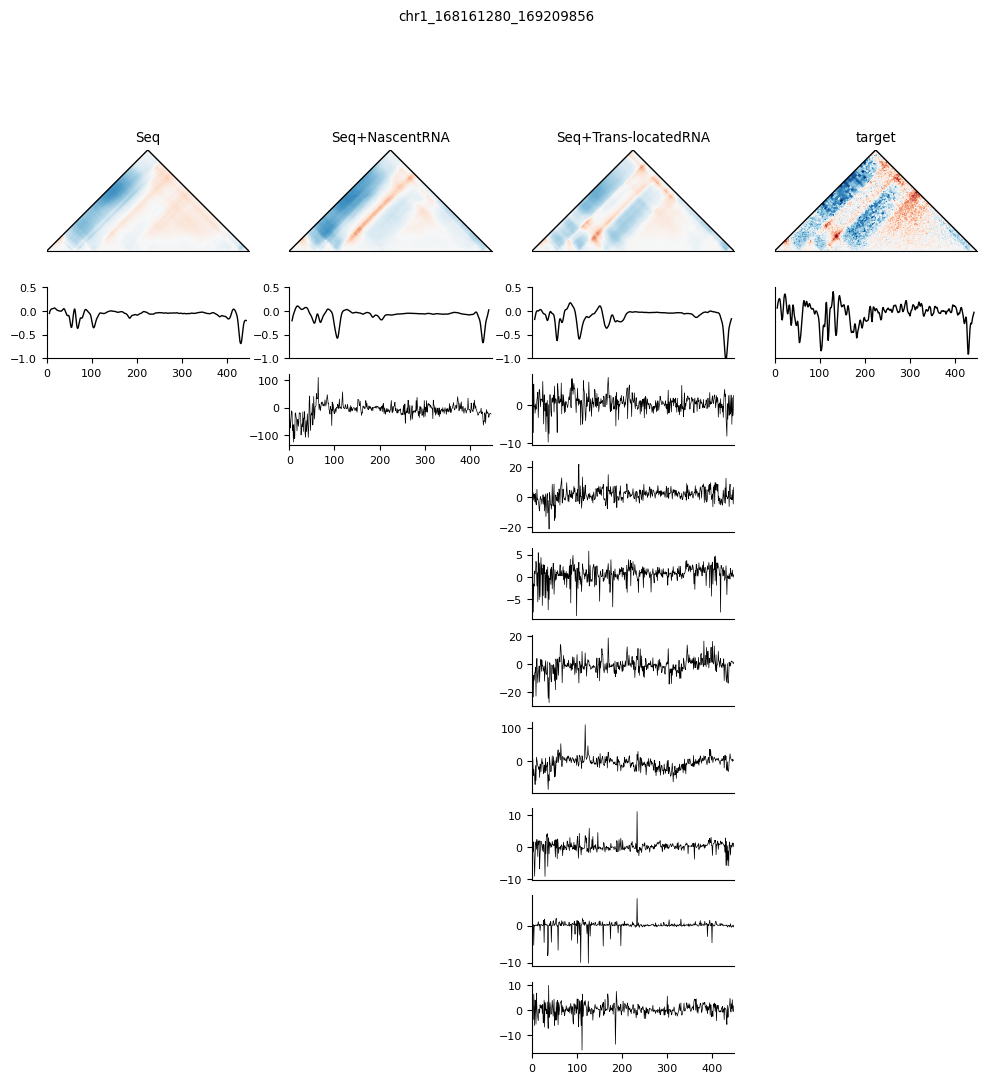

In [32]:
indexes = [124,191]

for index in indexes:
    plot_example_1(index,sequences_test,preds_dict,targets,rna_contribution_score,'contribution_scores')
    
   

## CaRNAs help predict cell-type-specific genome folding: Fig. 4 and Fig. S7-10

### Fig. 4A: SCC between experimental and predicted contact maps on the test set and its cell-type-specific subsets

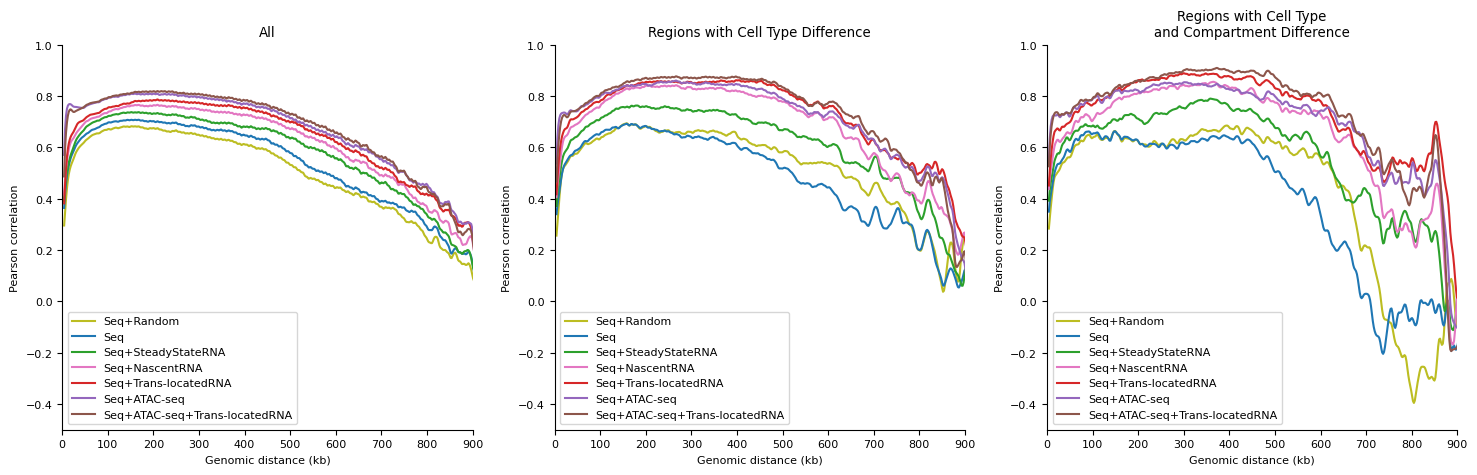

In [33]:
scc_file_name_list = ['test_seq_pearsonr_against_dist_HFF.txt','test_seq_pearsonr_against_dist_mse_0.3_HFF.txt',
                      'test_seq_pearsonr_against_dist_mse_0.3_compartment_B_to_A_HFF.txt']
models_list = ['Seq+Random','Seq','Seq+SteadyStateRNA','Seq+NascentRNA','Seq+Trans-locatedRNA','Seq+ATAC-seq','Seq+ATAC-seq+Trans-locatedRNA']

fig, ax = plt.subplots(1, 3,figsize=(18,5))
for (scc_file,pi,tn) in zip(scc_file_name_list,range(3),['All','Regions with Cell Type Difference','Regions with Cell Type\nand Compartment Difference']):
    for (ml,mcolor) in zip(models_list,model_colors):
        df_data = pd.read_table(f'{data_dir}/Best_models/Model_performance/{ml}/{scc_file}',header=0)
        df_data['Index'] = df_data['Index'].str.replace('_kb','',regex=False)
        df_data['Index'] = df_data['Index'].astype(float)
        ax[pi].plot(df_data['Index'],df_data['corrp'],color=mcolor,label=ml)
    ax[pi].set_xlim(0,900)
    ax[pi].set_xticks(np.arange(0, 901, 100))
    ax[pi].set_ylim(-0.5,1)
    ax[pi].set_xlabel('Genomic distance (kb)')
    ax[pi].set_ylabel('Pearson correlation')
    ax[pi].legend()
    ax[pi].set_title(tn)

#plt.savefig("HFF_SCC_performance.pdf")

### Fig. 4B: Model performance on the cell-type-specific subsets

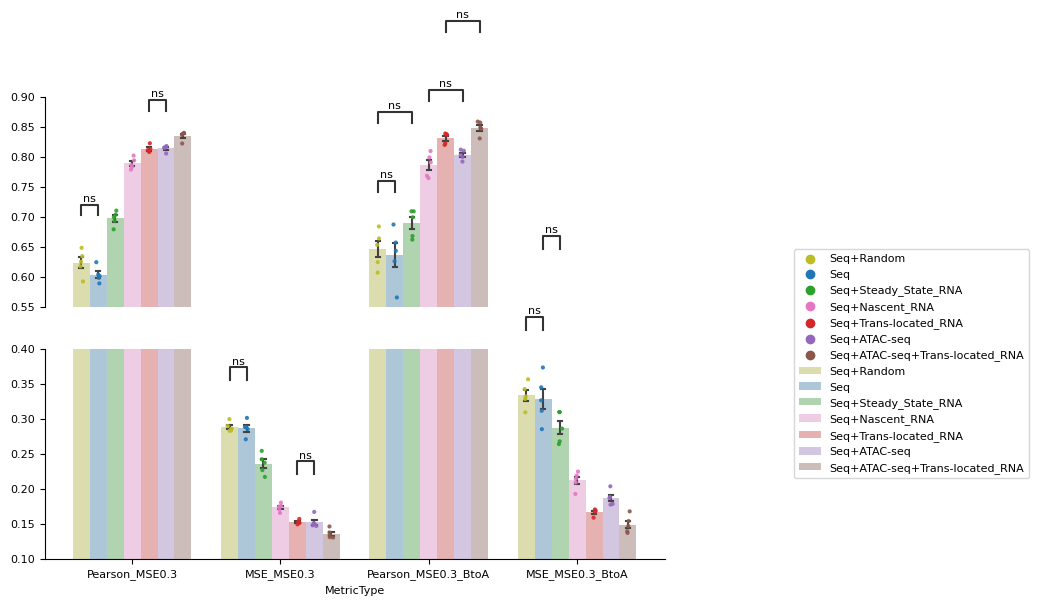

In [34]:
selected_metrics = ['Pearson_MSE0.3','MSE_MSE0.3','Pearson_MSE0.3_BtoA','MSE_MSE0.3_BtoA']
model_performance_df_sub = model_performance_df[model_performance_df['MetricType'].isin(selected_metrics)] 

pairs_correlation_combine = []
pairs_mse_combine = []
for sm in selected_metrics:
    for cp in non_sig_pairs_dict[sm]:
        if(('Pearson' in sm) or 'Spearman' in sm):
            pairs_correlation_combine.append([(sm,cp[0]),(sm,cp[1])])
        else:
            pairs_mse_combine.append([(sm,cp[0]),(sm,cp[1])])

fig, (ax1,ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(8,6))
ax1 = barplot_vis(ax1,model_performance_df_sub,selected_metrics,pairs_correlation_combine,model_order,model_colors,0.55,0.9)
ax1.spines['bottom'].set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_legend().remove()

ax2 = barplot_vis(ax2,model_performance_df_sub,selected_metrics,pairs_mse_combine,model_order,model_colors,0.1,0.4)
ax2.get_legend().remove()
ax2.legend(bbox_to_anchor=(1.2, 1.5),fontsize=8)

plt.show()
#plt.savefig(f'{plot_dir}/HFF_combined_performance_mse_diff.pdf')

### Fig. 4C: An example showing the contribution of trans-located RNAs to the prediction of some chromatin interactions

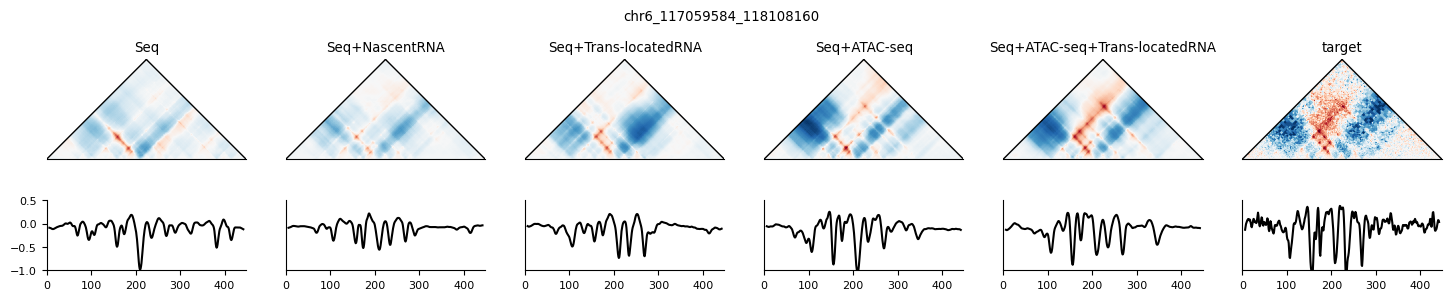

In [35]:
indexes = [361]
for i in indexes:
    index_seq_info = sequences_test.iloc[i]
    index_seq_info_str = '_'.join([index_seq_info['chrom'],index_seq_info['start'].astype(str),index_seq_info['end'].astype(str)])
    fig, ax = plt.subplots(nrows=2,ncols=6,figsize=(18,3),gridspec_kw={'height_ratios': [2,1]})
    for (mns,pi) in zip(['Seq','Seq+NascentRNA','Seq+Trans-locatedRNA','Seq+ATAC-seq','Seq+ATAC-seq+Trans-locatedRNA'],range(5)):
        pcolormesh_45deg(ax[0,pi], from_upper_triu(preds_dict[mns][i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
        ax[0,pi].set_title(mns)
        pred_insulation = insulation_track(from_upper_triu(preds_dict[mns][i,:], 448, 2),window_size=5)
        ax[1,pi].plot(pred_insulation,c='black')
        ax[1,pi].set_xlim([0,448])
        ax[1,pi].set_ylim([-1,0.5])
        if(pi>0):
            ax[1,pi].set_yticks([])
            
    pcolormesh_45deg(ax[0,5], from_upper_triu(targets[i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
    ax[0,5].set_title('target')
    target_insulation = insulation_track(from_upper_triu(targets[i,:], 448, 2),window_size=5)
    ax[1,5].plot(target_insulation,c='black')
    ax[1,5].set_xlim([0,448])
    ax[1,5].set_ylim([-1,0.5])
    ax[1,5].set_yticks([])
    fig.suptitle(index_seq_info_str)
    #plt.savefig(f'{plot_dir}/HFF_exmaple{i}.pdf')

### Supplementary Figure 7: Cell-type-specific test regions

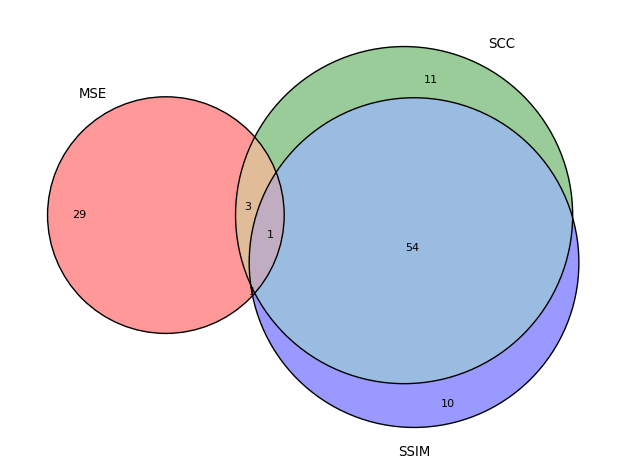

In [36]:
venn3(subsets=(29, 11, 3, 10, 1, 54, 1), 
      set_labels=('MSE', 'SCC', 'SSIM'))
  
venn3_circles(subsets=(29, 11, 3, 10, 1, 54, 1),
               linewidth=1)
plt.tight_layout()

#plt.savefig(f'{plot_dir}/H1_HFF_diff_regions.pdf')

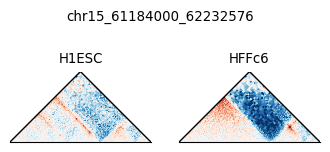

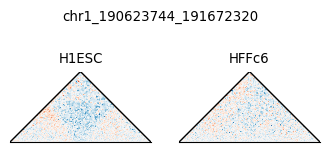

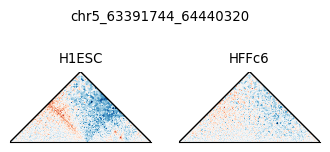

In [37]:
H1_targets = h5py.File(f'{data_dir}/Best_models/Targets_predictions/Targets/H1_test_targets.h5','r')['targets'][:,:,0]

indexes = [375,172,52]

for i in indexes:
    index_seq_info = sequences_test.iloc[i]
    index_seq_info_str = '_'.join([index_seq_info['chrom'],index_seq_info['start'].astype(str),index_seq_info['end'].astype(str)])
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(4,2))
    pcolormesh_45deg(ax[0], from_upper_triu(H1_targets[i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
    ax[0].set_title('H1ESC')
    pcolormesh_45deg(ax[1], from_upper_triu(targets[i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
    ax[1].set_title('HFFc6')
    plt.suptitle(index_seq_info_str)
    #plt.savefig(f'{plot_dir}/HFF_exmaple{i}_diff.pdf')

### Supplementary Figure 8: Model performance on the cell-type-specific subsets (MSE) - additional metrics

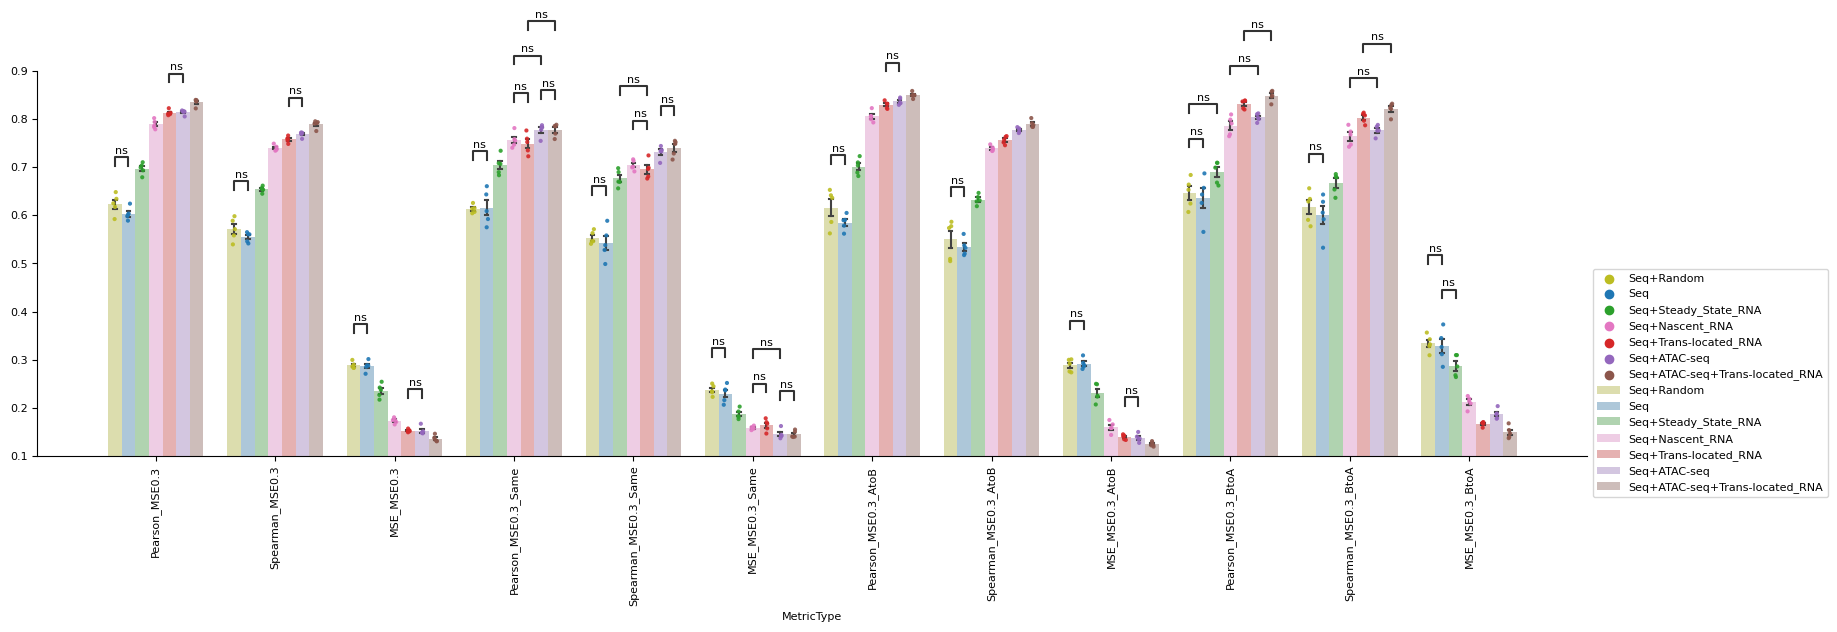

In [38]:
model_performance_df_sub = model_performance_df[model_performance_df['MetricType'].str.contains('MSE0.3')] 
selected_metrics = list(model_performance_df_sub['MetricType'].unique())
pairs = []
for sm in selected_metrics:
    for cp in non_sig_pairs_dict[sm]:
        pairs.append([(sm,cp[0]),(sm,cp[1])])
        
fig, ax = plt.subplots(figsize=(20,5))
ax = barplot_vis(ax,model_performance_df_sub,selected_metrics,pairs,model_order,model_colors,0.1,0.9)
ax.legend(bbox_to_anchor=(1.0, 0.5),fontsize=8)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
#plt.savefig(f'{plot_dir}/HFF_combined_performance_MSE_diff_regions.pdf')

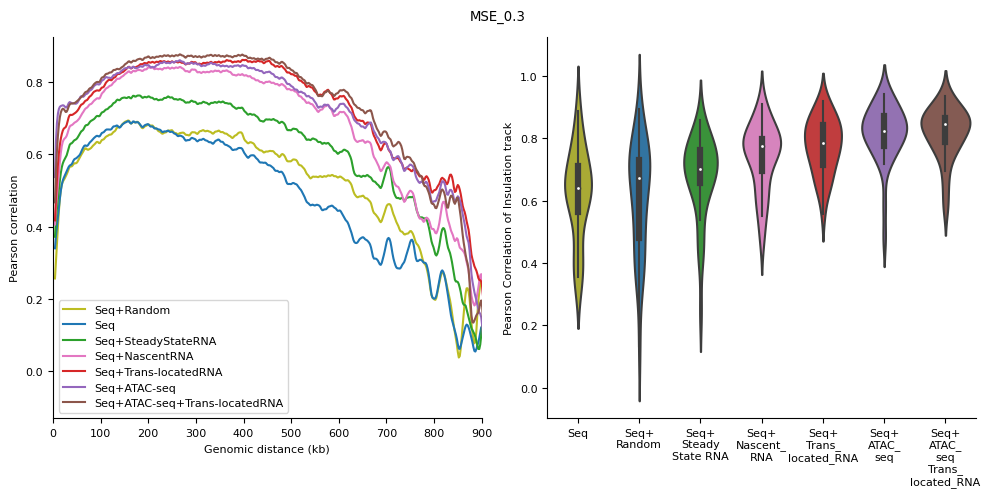

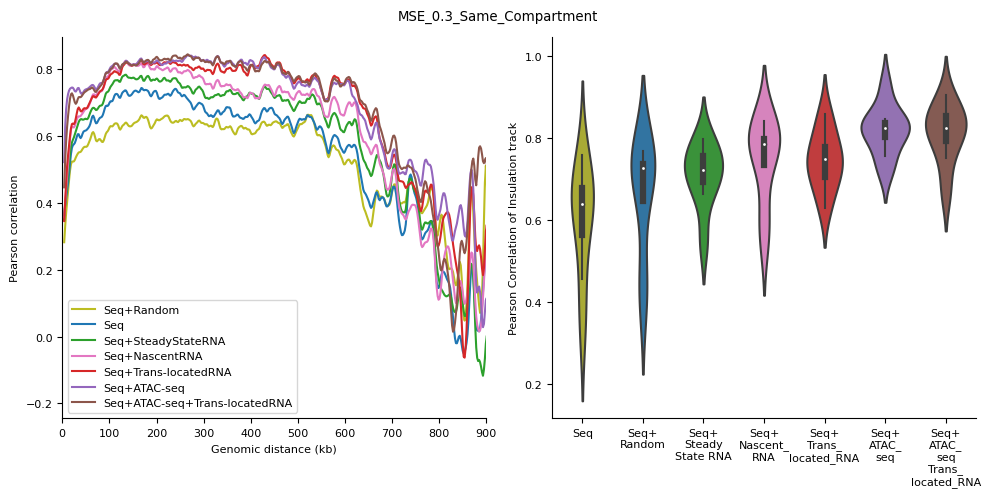

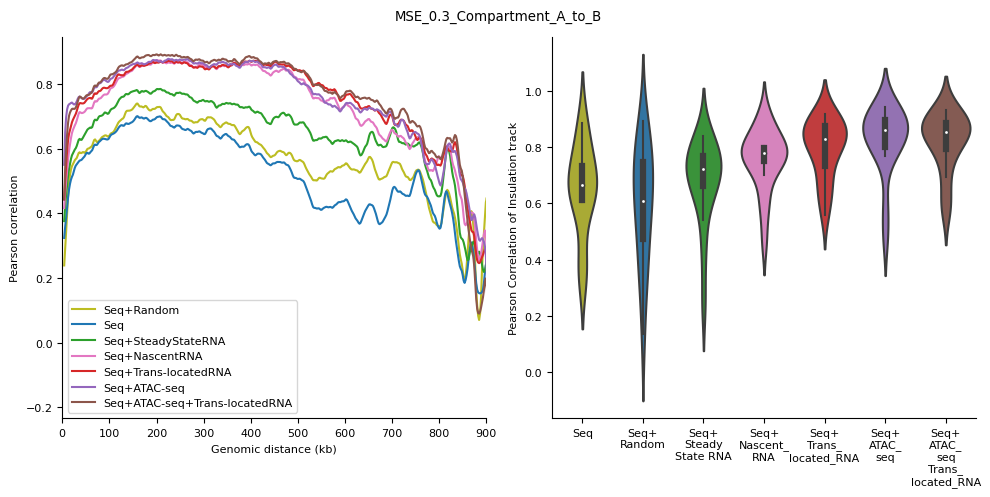

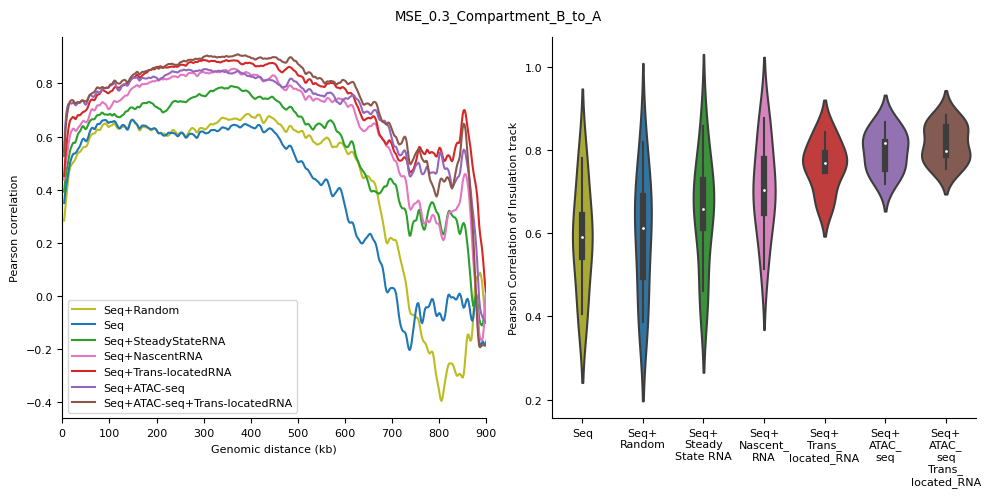

In [39]:
titles = ['MSE_0.3','MSE_0.3_Same_Compartment','MSE_0.3_Compartment_A_to_B','MSE_0.3_Compartment_B_to_A']
scc_files = ['test_seq_pearsonr_against_dist_mse_0.3_HFF.txt','test_seq_pearsonr_against_dist_mse_0.3_same_compartment_HFF.txt', \
              'test_seq_pearsonr_against_dist_mse_0.3_compartment_A_to_B_HFF.txt','test_seq_pearsonr_against_dist_mse_0.3_compartment_B_to_A_HFF.txt']
insulation_files = ['test_seq_insulation_corr_mse_0.3_HFF.txt','test_seq_insulation_corr_mse_0.3_same_compartment_HFF.txt', \
            'test_seq_insulation_corr_mse_0.3_compartment_A_to_B_HFF.txt','test_seq_insulation_corr_mse_0.3_compartment_B_to_A_HFF.txt']

for (title,scc_file,insulation_file) in zip(titles,scc_files,insulation_files):
    insulation_data = get_metric_df(insulation_file,'TAD')
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    for (ml,mcolor) in zip(models_list,model_colors):
        df_data = pd.read_table(f'{data_dir}/Best_models/Model_performance/{ml}/{scc_file}',header=0)
        df_data['Index'] = df_data['Index'].str.replace('_kb','',regex=False)
        df_data['Index'] = df_data['Index'].astype(float)
        ax1.plot(df_data['Index'],df_data['corrp'],color=mcolor,label=ml)
    ax1.set_xlim(0,900)
    ax1.set_xticks(np.arange(0, 901, 100))
    ax1.set_xlabel('Genomic distance (kb)')
    ax1.set_ylabel('Pearson correlation')
    ax1.legend(fontsize=8)
    ax1.legend()
    
    sns.violinplot(data=insulation_data,ax=ax2,palette=model_colors)
    ax2.set_xticklabels(labels=["Seq","Seq+\nRandom","Seq+\nSteady\nState RNA","Seq+\nNascent_\nRNA","Seq+\nTrans_\nlocated_RNA","Seq+\nATAC_\nseq","Seq+\nATAC_\nseq\nTrans_\nlocated_RNA"], rotation=0, va="top",fontsize=8)
    ax2.set_ylabel('Pearson Correlation of Insulation track')

    fig.suptitle(title)
    plt.tight_layout()
    #plt.savefig("HFF_"+title+"_performance.pdf")


### Supplementary Figure 9: Model performance on the cell-type-specific subsets (MSE, SCC, SSIM)

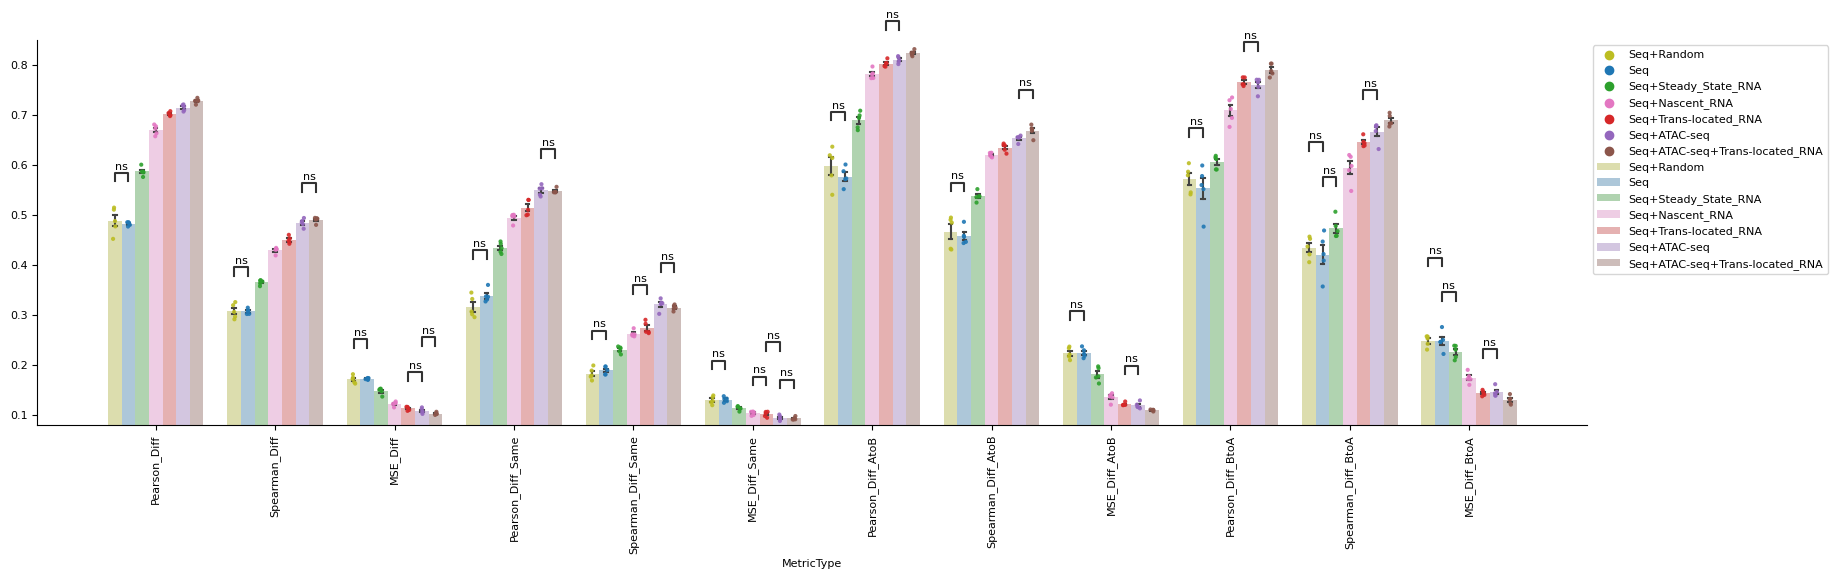

In [40]:
model_performance_df_sub = model_performance_df[model_performance_df['MetricType'].str.contains('Diff')] 
selected_metrics = list(model_performance_df_sub['MetricType'].unique())
pairs = []
for sm in selected_metrics:
    for cp in non_sig_pairs_dict[sm]:
        pairs.append([(sm,cp[0]),(sm,cp[1])])
        
fig, ax = plt.subplots(figsize=(20,5))
ax = barplot_vis(ax,model_performance_df_sub,selected_metrics,pairs,model_order,model_colors,0.08,0.85)
ax.legend(bbox_to_anchor=(1.0, 1.0),fontsize=8)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
#plt.savefig(f'{plot_dir}/HFF_combined_performance_diff_regions.pdf')

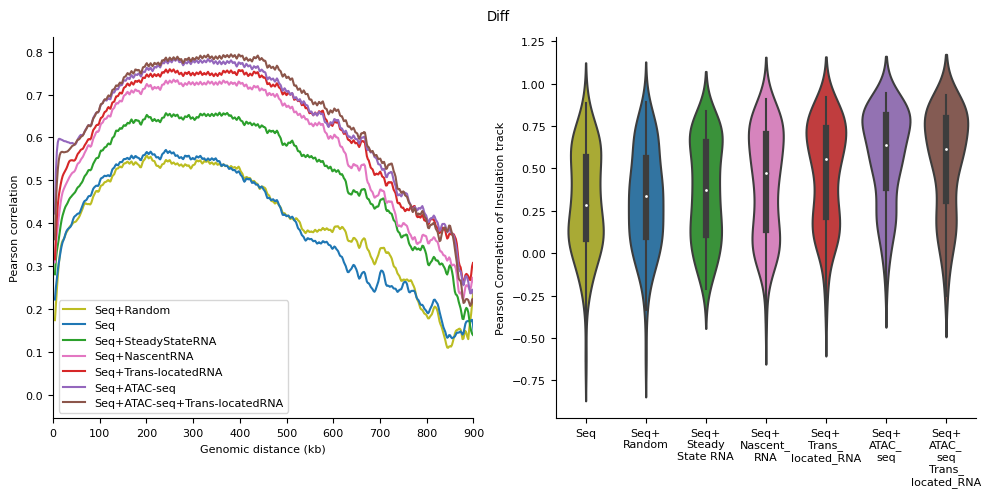

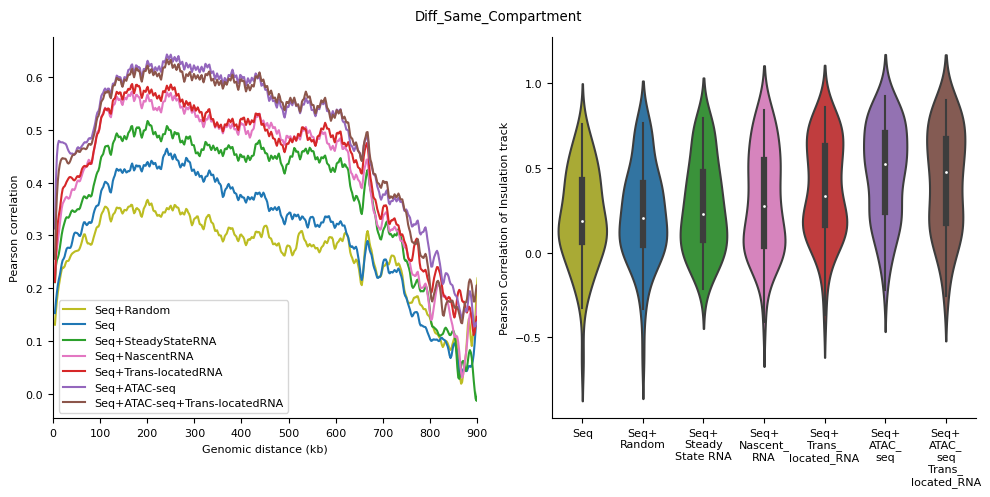

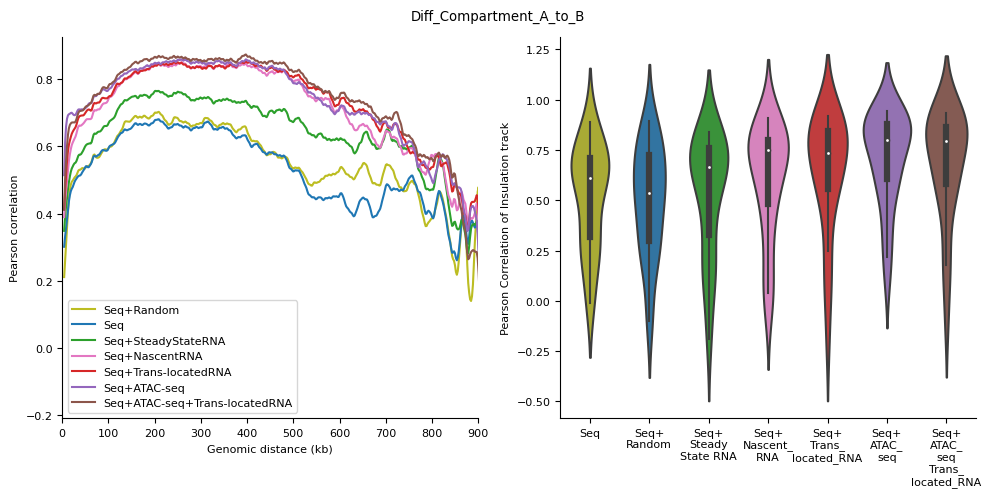

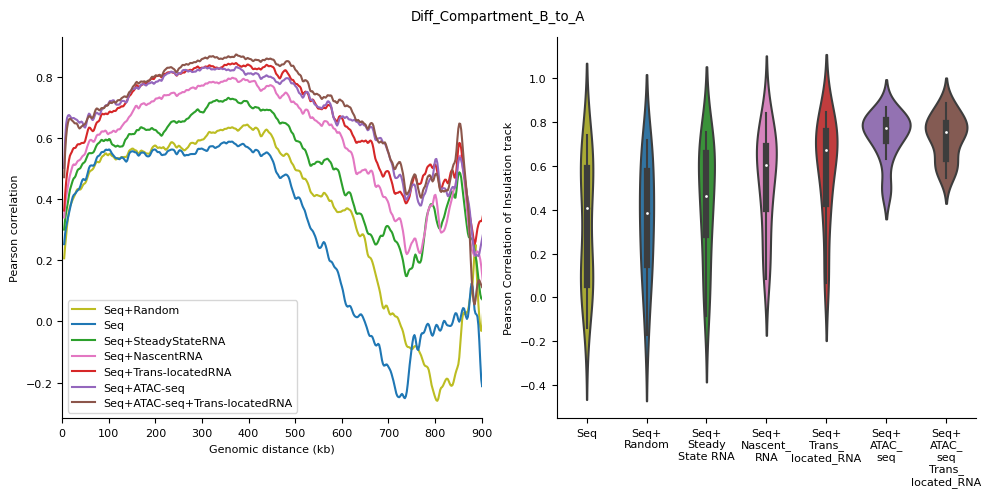

In [41]:
titles = ['Diff','Diff_Same_Compartment','Diff_Compartment_A_to_B','Diff_Compartment_B_to_A']
scc_files = ['test_seq_pearsonr_against_dist_diff_HFF.txt', 'test_seq_pearsonr_against_dist_diff_same_compartment_HFF.txt', \
             'test_seq_pearsonr_against_dist_diff_compartment_A_to_B_HFF.txt','test_seq_pearsonr_against_dist_diff_compartment_B_to_A_HFF.txt']
insulation_files = ['test_seq_insulation_corr_diff_HFF.txt','test_seq_insulation_corr_diff_same_compartment_HFF.txt', \
            'test_seq_insulation_corr_diff_compartment_A_to_B_HFF.txt','test_seq_insulation_corr_diff_compartment_B_to_A_HFF.txt']

for (title,scc_file,insulation_file) in zip(titles,scc_files,insulation_files):
    insulation_data = get_metric_df(insulation_file,'TAD')
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    for (ml,mcolor) in zip(models_list,model_colors):
        df_data = pd.read_table(f'{data_dir}/Best_models/Model_performance/{ml}/{scc_file}',header=0)
        df_data['Index'] = df_data['Index'].str.replace('_kb','',regex=False)
        df_data['Index'] = df_data['Index'].astype(float)
        ax1.plot(df_data['Index'],df_data['corrp'],color=mcolor,label=ml)
    ax1.set_xlim(0,900)
    ax1.set_xticks(np.arange(0, 901, 100))
    ax1.set_xlabel('Genomic distance (kb)')
    ax1.set_ylabel('Pearson correlation')
    ax1.legend(fontsize=8)
    
    sns.violinplot(data=insulation_data,ax=ax2,palette=model_colors)
    ax2.set_xticklabels(labels=["Seq","Seq+\nRandom","Seq+\nSteady\nState RNA","Seq+\nNascent_\nRNA","Seq+\nTrans_\nlocated_RNA","Seq+\nATAC_\nseq","Seq+\nATAC_\nseq\nTrans_\nlocated_RNA"], rotation=0, va="top",fontsize=8)
    ax2.set_ylabel('Pearson Correlation of Insulation track')

    fig.suptitle(title)
    plt.tight_layout()
    #plt.savefig("HFF_"+title+"_performance.pdf")


### Supplementary Figure 10: Model inputs and contribution scores for the example in Fig. 4

In [42]:
def plot_example_2(row_index,seqs_info,pred_data,target_data,input_data,input_label):
    i = row_index
    index_seq_info = seqs_info.iloc[i]
    index_seq_info_str = '_'.join([index_seq_info['chrom'],index_seq_info['start'].astype(str),index_seq_info['end'].astype(str)])
    fig, ax = plt.subplots(nrows=11,ncols=7,figsize=(20,13),gridspec_kw={'height_ratios': [2,1,1,1,1,1,1,1,1,1,1]})
    for (mns,pi) in zip(['Seq','Seq+SteadyStateRNA','Seq+NascentRNA','Seq+Trans-locatedRNA','Seq+ATAC-seq','Seq+ATAC-seq+Trans-locatedRNA'],range(6)):
        pcolormesh_45deg(ax[0,pi], from_upper_triu(pred_data[mns][i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
        ax[0,pi].set_title(mns)
        pred_insulation = insulation_track(from_upper_triu(pred_data[mns][i,:], 448, 2),window_size=5)
        ax[1,pi].plot(pred_insulation,c='black',linewidth=1.0)
        ax[1,pi].set_xlim([0,448])
        ax[1,pi].set_ylim([-1,0.5]) 
        
        if(mns=='Seq'):
            for j in range(2,11):
                ax[j,pi].axis('off')
        elif((mns=='Seq+SteadyStateRNA')or(mns=='Seq+NascentRNA')or(mns=='Seq+ATAC-seq')):
            ax[1,pi].set_xticks([])
            ax[2,pi].plot(input_data[mns][i,32:480,0],c='black',linewidth=0.5)
            ax[2,pi].set_xlim([0,448])
            for j in range(3,11):
                ax[j,pi].axis('off')
        elif(mns=='Seq+Trans-locatedRNA'):
            ax[1,pi].set_xticks([])
            for (j,k) in zip(range(2,10),[1,2,0,4,5,3,6,7]):
                ax[j,pi].plot(input_data[mns][i,32:480,k],c='black',linewidth=0.5)
                ax[j,pi].set_xlim([0,448])
                if(j<9):
                    ax[j,pi].set_xticks([])
            ax[10,pi].axis('off') 
        else:
            ax[1,pi].set_xticks([])
            for (j,k) in zip(range(2,11),[1,2,0,4,5,3,6,7,8]):
                ax[j,pi].plot(input_data[mns][i,32:480,k],c='black',linewidth=0.5)
                ax[j,pi].set_xlim([0,448])
                if(j<10):
                    ax[j,pi].set_xticks([])
        
        
    pcolormesh_45deg(ax[0,6], from_upper_triu(target_data[i,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)
    ax[0,6].set_title('target')
    target_insulation = insulation_track(from_upper_triu(target_data[i,:], 448, 2),window_size=5)
    ax[1,6].plot(target_insulation,c='black',linewidth=1.0)
    ax[1,6].set_xlim([0,448])
    ax[1,6].set_ylim([-1,0.5])
    ax[1,6].set_yticks([])
    for j in range(2,11):
        ax[j,6].axis('off')
    fig.suptitle(index_seq_info_str)
    #plt.savefig(f'{plot_dir}/HFF_exmaple{i}_rna_{input_label}_100923.pdf')

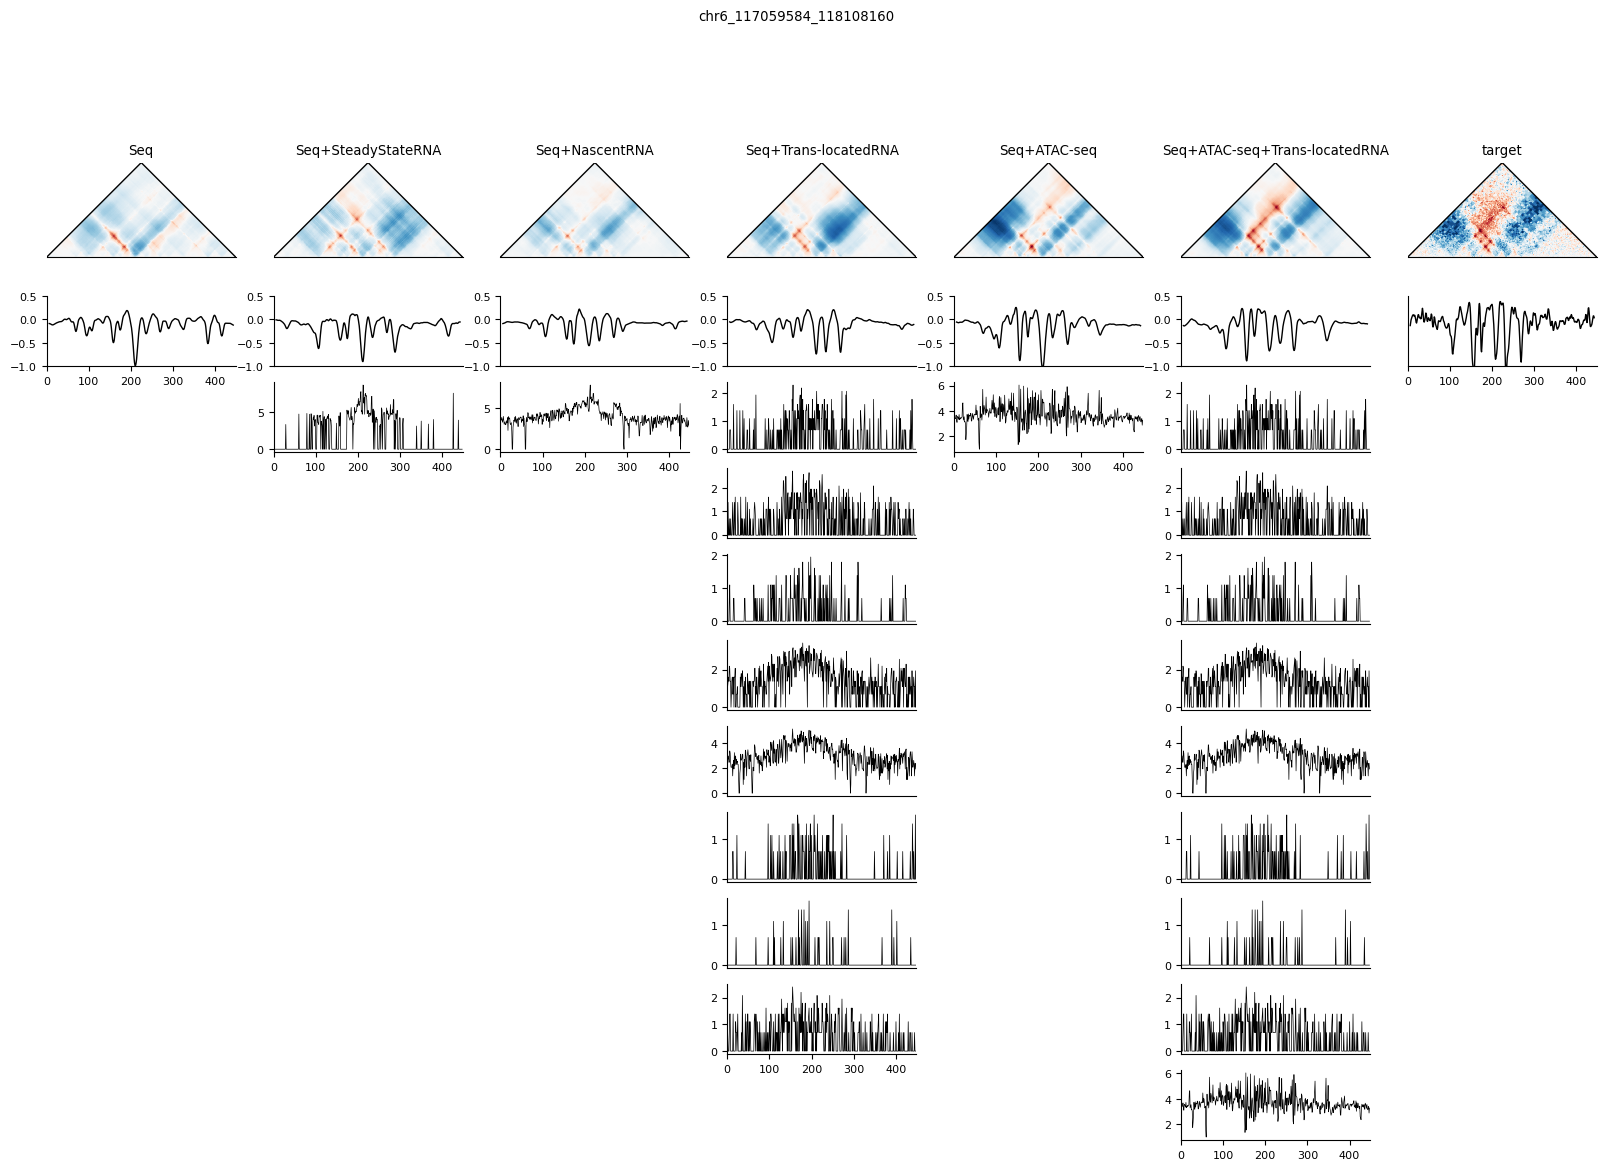

In [43]:
plot_example_2(361,sequences_test,preds_dict,targets,rna_inputs,'inputs')

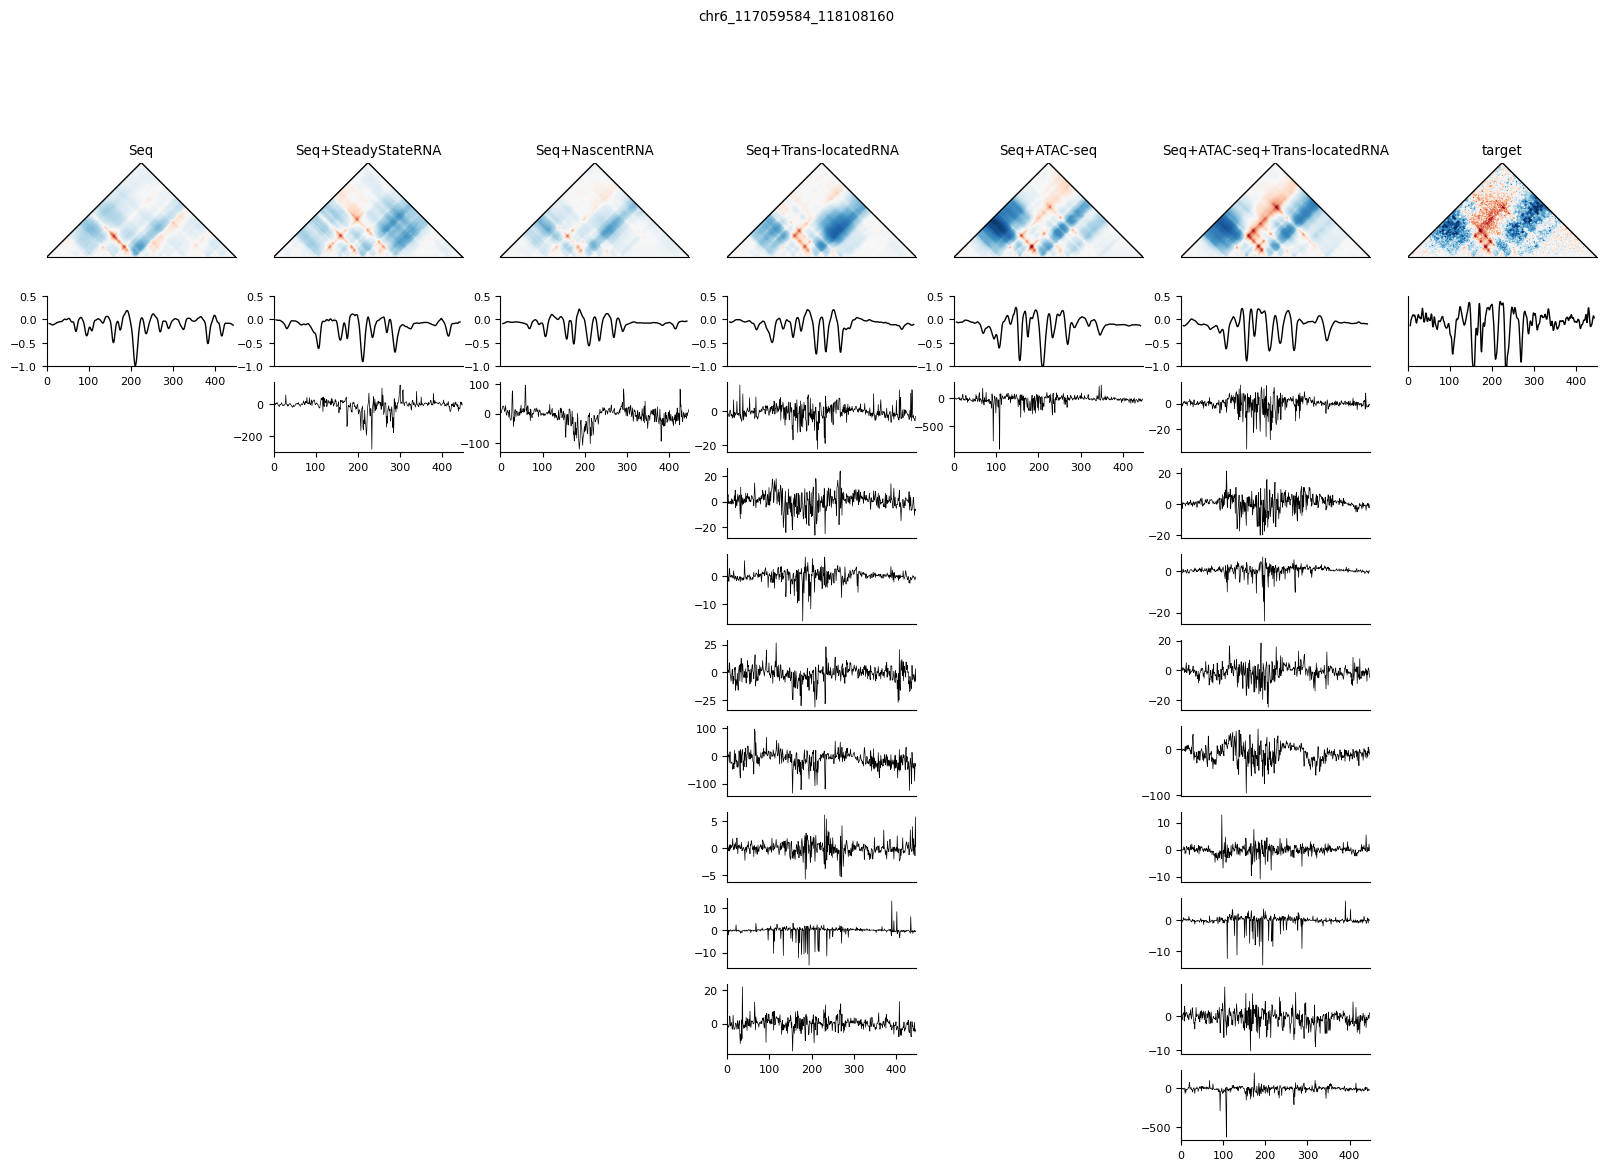

In [44]:
plot_example_2(361,sequences_test,preds_dict,targets,rna_contribution_score,'contribution_scores')

## CaRNAs are associated with TAD boundaries, loop anchors and nuclear structures: Fig. 5 & Fig. S11-19

### Fig. 5B: The enrichment of regions with high contribution at TAD boundaries, loop anchors, SPIN and chromHMM states

In [45]:
def get_value_count_dict(df_dict,df_keys,df_keys_sub,df_keys_sub2,label):
    df_list = {}
    count_name_orders = ['CTCF','CTCF_peak','ATACseq_peak','active_promoter','enhancer']
    chromHMM_order=['U5_Tx','U13_ZNF/Rpts', 'U14_Het', 'U17_ReprPC', 'U18_Quies']
    SPIN_order = ['Speckle', 'Interior_Act1', 'Interior_Act2', 'Interior_Act3', 'Interior_Repr1', 'Interior_Repr2', 'Near_Lm1', 'Near_Lm2', 'Lamina']
    TAD_order = ['Shared_TAD_NoDiff','Shared_TAD_Diff_H1_High','Shared_TAD_Diff_HFF_High','HFF_Unique_TAD']
    loop_order = ['Shared_Loop_Anchor','HFF_Unique_Loop_Anchor']
    compartment_order = ['CompartmentA','CompartmentB']
    name_orders = count_name_orders+chromHMM_order+compartment_order+TAD_order+loop_order+SPIN_order
    for df_key in df_keys:
        df = df_dict[df_key]
        for cname in count_name_orders:
            if df_key in df_list:
                df_list[df_key].append(df[df[cname]>0].shape[0])
            else:
                df_list[df_key] = []
                df_list[df_key].append(df[df[cname]>0].shape[0])
        df_list[df_key] += df['chromHMM'].value_counts().reindex(chromHMM_order).to_list()
        df_list[df_key] += df['compartment'].value_counts().reindex(compartment_order).to_list()
        df_list[df_key] += df['TAD'].value_counts().reindex(TAD_order).to_list()
        df_list[df_key] += df['loop'].value_counts().reindex(loop_order).to_list()
        df_list[df_key] += df['SPIN'].value_counts().reindex(SPIN_order).to_list()
    df_columns = {}
    df_columns['Anno'] = name_orders
    for df_key in df_keys:
        df_columns[f'{label}_{df_key}'] = df_list[df_key]
    result_df = pd.DataFrame(df_columns)
    for df_key_sub in df_keys_sub:
        result_df[f'{label}_{df_key_sub}_FC'] = (result_df[f'{label}_{df_key_sub}']/df_dict[df_key_sub].shape[0])/(result_df[f'{label}_{df_keys_sub2}']/df_dict[df_keys_sub2].shape[0])
    return result_df
    

In [46]:
def get_FC_df(input_names,subsets,values_df,anno_df,datadir):
    selected_annos = {}
    selected_df = pd.DataFrame()
    
    for input_name in input_names:
        FC_df = {}
        for subset in subsets:
            input_selected = pd.read_table(f'{datadir}/{input_name}/{input_name}_{subset}_important_bins.txt',sep='\t',header=0)
            input_selected_anno = input_selected.merge(values_df,on=['chrom','start','end']).merge(anno_df,on=['chrom','start','end'])
            FC_df[subset] = input_selected_anno[input_selected_anno[input_name]>0]
        selected_annos[input_name] = get_value_count_dict(FC_df,subsets,subsets[:-1],subsets[-1],input_name).set_index('Anno')
        selected_df = pd.concat([selected_df, selected_annos[input_name]],axis=1)
        
    input_names_subs_log2 = []
    for input_name in input_names:
        for subset1 in subsets[:-1]:
            selected_df[f'{input_name}_{subset1}_log2FC'] = np.log2(selected_df[f'{input_name}_{subset1}_FC'])
            input_names_subs_log2.append(f'{input_name}_{subset1}_log2FC')
        
    selected_df_log2 = selected_df[input_names_subs_log2] 
    return selected_df_log2


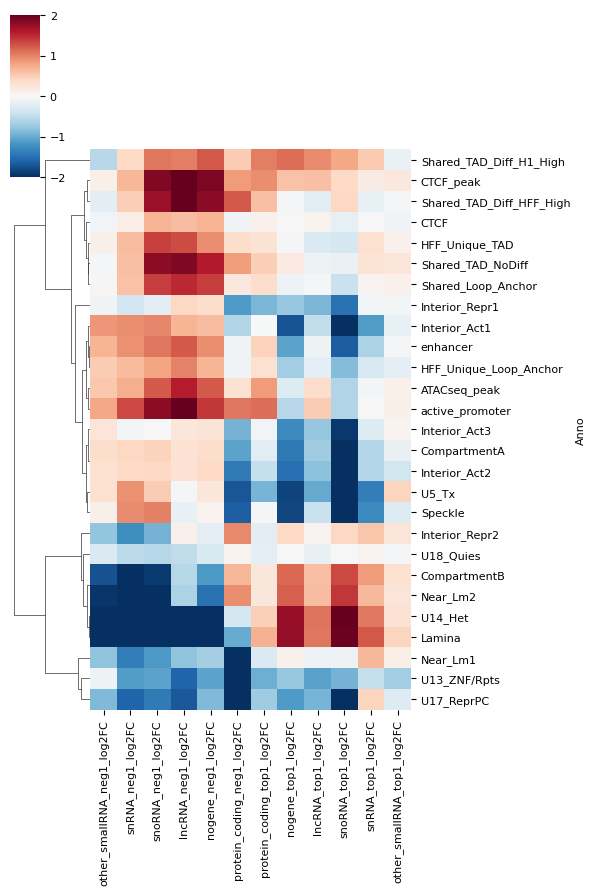

In [47]:
bin_annos = pd.read_table(f'{data_dir}/Genomic_bin_data/HFFc6_bin_annos_2048',sep='\t',header=0)
trans_RNA_values = pd.read_table(f'{data_dir}/Genomic_bin_data/HFFc6_RNA_class_count_long_cis_trans_2048',sep='\t',header=0)
rna_labels = ['snRNA','snoRNA','other_smallRNA','lncRNA','protein_coding','nogene']
rna_df_keys = ['top1','neg1','all']
data_dir_sub = f'{data_dir}/Model_interpretation/Seq+Trans-locatedRNA'
trans_rna_FC_log2 = get_FC_df(rna_labels,rna_df_keys,trans_RNA_values,bin_annos,data_dir_sub) 

trans_rna_FC_log2 = trans_rna_FC_log2[['other_smallRNA_neg1_log2FC','snRNA_neg1_log2FC','snoRNA_neg1_log2FC','lncRNA_neg1_log2FC','nogene_neg1_log2FC','protein_coding_neg1_log2FC',
                                     'protein_coding_top1_log2FC','nogene_top1_log2FC','lncRNA_top1_log2FC','snoRNA_top1_log2FC','snRNA_top1_log2FC','other_smallRNA_top1_log2FC']]
g = sns.clustermap(trans_rna_FC_log2,cmap='RdBu_r',col_cluster=False,yticklabels=True,xticklabels=True,figsize=(6,9),vmin=-2,vmax=2,metric="correlation",method='average')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(),fontsize=8)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8)
plt.show()
#plt.savefig(f'{plot_dir}/RNAType_Selected_1per_Bins_Enrichment_plot.pdf')

### Fig. 5C: Example of RNAs that preferentially interact with genomic regions with high contribution scores

In [48]:
def plot_RNA_genomic_region_interaction_ratio(rantypes,genes,subregs,col_names,colors,fig_label):
    for rt,gene_name in zip(rantypes,genes):
        for i,subreg in enumerate(subregs):
            if('ATACseq' in subreg):
                df_anno = pd.read_table(f'{data_dir}/Model_interpretation/Seq+Trans-locatedRNA/{rt}/RNAs_interacted_{rt}_{subreg}_bins.txt',sep='\t',header=0)
            else:
                df_anno = pd.read_table(f'{data_dir}/Model_interpretation/Seq+Trans-locatedRNA/{rt}/RNAs_interacted_{rt}_{subreg}_important_bins_pos.txt',sep='\t',header=0)
            df_anno_sub = df_anno[df_anno['Geneinfo'].str.contains(gene_name)][['Geneinfo','bin_ratio']].rename(columns={"bin_ratio": subreg})
            if(i==0):
                gene_anno_df = df_anno_sub.copy()
            else:
                gene_anno_df=gene_anno_df.merge(df_anno_sub,on=['Geneinfo'])
        gene_anno_df.columns=['Geneinfo']+col_names
        gene_anno_df[['GeneID','Gene','GeneType','GeneCoord']] = gene_anno_df['Geneinfo'].str.split(pat = '|', expand = True)
        gene_df = gene_anno_df[['Gene']+col_names]
      
        fig, ax = plt.subplots(1,len(gene_name.split('|')),figsize=(3*len(gene_name.split('|')),3))
    
        if(len(gene_name.split('|'))>1): 
            for i in range(len(gene_name.split('|'))):
                ax[i].bar(gene_df.columns[1:],gene_df.iloc[i,1:],color=colors)
                ax[i].set_ylabel("Proportion")
                ax[i].set_title(gene_df.iloc[i,0])
                for tick in ax[i].get_xticklabels():
                    tick.set_rotation(90)
            
                if(i>=1):
                    ax[i].set_ylabel("")
        else:
            ax.bar(gene_df.columns[1:],gene_df.iloc[0,1:],color=colors)
            ax.set_ylabel("Proportion")
            ax.set_title(gene_df.iloc[0,0])
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.3)
        #plt.savefig(f'{plot_dir}/HFF_{rt}_Selected_RNAs_InteractedBins_Barplot_{fig_label}.pdf')
    

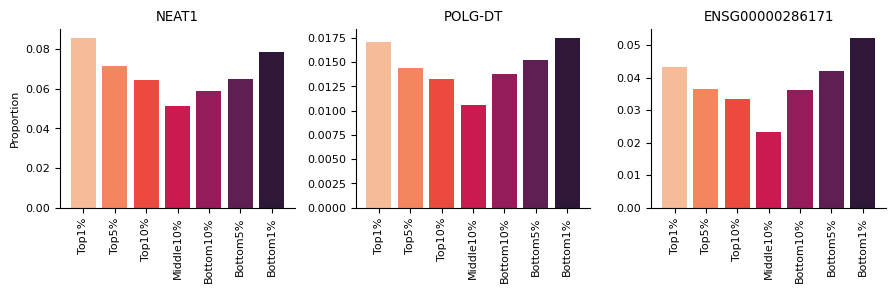

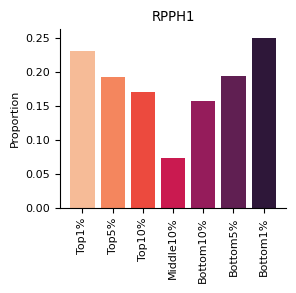

In [49]:
RNA_type = ['lncRNA','other_smallRNA']
selected_RNAs = ['NEAT1|ENSG00000286171|POLG-DT','RPPH1']
subsets = ['top1','top5','top10','mid10','neg10','neg5','neg1']
subset_names = ['Top1%','Top5%','Top10%','Middle10%','Bottom10%','Bottom5%','Bottom1%']

palette_r = sns.color_palette("rocket_r", 7)
reg_color = [palette_r[0],palette_r[1],palette_r[2],palette_r[3],palette_r[4],palette_r[5],palette_r[6]]
plot_RNA_genomic_region_interaction_ratio(RNA_type,selected_RNAs,subsets,subset_names,reg_color,'fig5')
    

### Fig. 5D: RNAs transcribed from repetitive elements at the interactions between DNA and RNAs derived from unknown genes

Text(0, 0.5, 'Proportion')

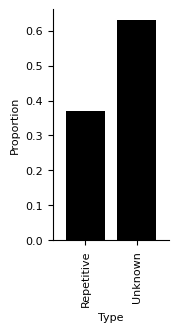

In [50]:
Rpt_ratio = [['Repetitive', 0.37],['Unknown', 0.63]]
Rpt_ratio_df = pd.DataFrame(Rpt_ratio, columns=['Type', 'Ratio'])

fig, ax = plt.subplots(figsize=(1.5,3))
Rpt_ratio_df.plot(x='Type',kind='bar',stacked=False,color= 'black',width=0.76,ax=ax,legend=False)
ax.set_ylabel('Proportion')
#plt.savefig(f'{plot_dir}/HFF_Unknown_RNA_DNA_Distribution.pdf')

### Fig. 5E: Alu elements at RNA-DNA interactions that might form R-loops

Text(0, 0.5, 'Proportion')

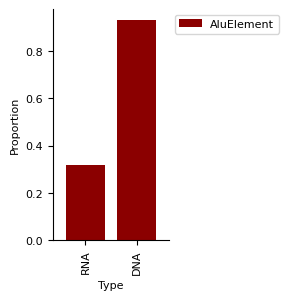

In [51]:
Alu_ratio = [['RNA',0.32],['DNA',0.93]]
Alu_ratio_df = pd.DataFrame(Alu_ratio, columns=['Type', 'AluElement'])

fig, ax = plt.subplots(figsize=(1.5,3))
Alu_ratio_df.plot(x='Type',kind='bar',stacked=False,color= 'darkred',width=0.76,ax=ax).legend(bbox_to_anchor=(1.0, 1.0),fontsize=8)
ax.set_ylabel('Proportion')
#plt.savefig(f'{plot_dir}/HFF_Candidate_Rloop_RNA_DNA_Distribution.pdf')

### Fig. 5F: RNA-DNA interactions that might form R-loops at TAD boundaries and loop anchors

In [52]:
TAD_col = ['Shared_TAD_NoDiff','Shared_TAD_Diff_HFF_High','HFF_Unique_TAD','Shared_TAD_Diff_H1_High','H1_Unique_TAD']
loop_col = ['Shared_Loop_Anchor','HFF_Unique_Loop_Anchor','H1_Unique_Loop_Anchor']
R_loop_TAD_count = np.array([3320,396,1789,223,1266])
TAD_count = np.array([6160,747,3641,598,4288])
R_loop_loop_count = np.array([16686,6638,2379])
loop_count = np.array([27014,13007,6692])
R_loop_TAD_ratio = R_loop_TAD_count/TAD_count
R_loop_loop_ratio = R_loop_loop_count/loop_count

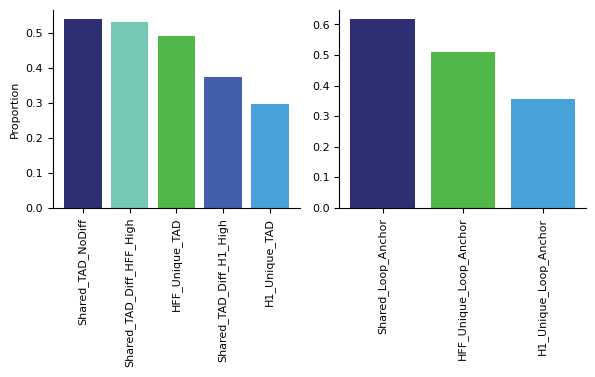

In [53]:
colors_1 = ['#2D2E73','#75C9B4','#51B748','#415FAB','#49A1D9']
colors_2 = ['#2D2E73','#51B748','#49A1D9']

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].bar(TAD_col,R_loop_TAD_ratio,color=colors_1)
ax[0].set_ylabel("Proportion")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
        
ax[1].bar(loop_col,R_loop_loop_ratio,color=colors_2)
ax[1].set_ylabel("")
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
#plt.savefig(f'{plot_dir}/HFF_Candidate_R_loop_Barplot.pdf')

### Fig. 5G: An example showing the contribution of trans-located caRNAs at chromatin loops by potentially forming R-loops at Alu elements

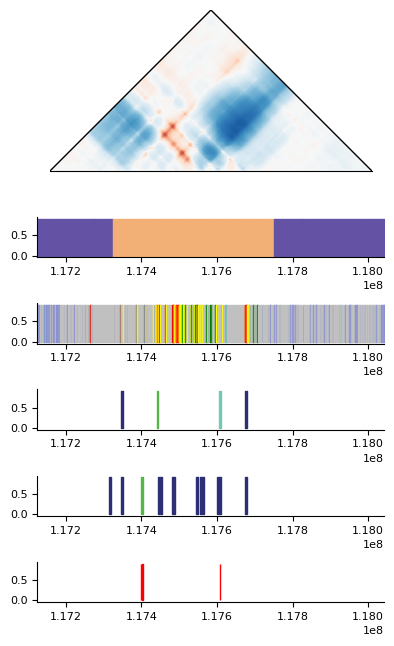

In [54]:
anno_states = ['SPIN_state','chromHMM_state','TAD_boundaries','Loop_anchor','Repetitive_element']
index_seq_info = sequences_test.iloc[361]
index_seq_info_str = '_'.join([index_seq_info['chrom'],index_seq_info['start'].astype(str),index_seq_info['end'].astype(str)])
fig, ax = plt.subplots(nrows=6,figsize=(4,6.5),gridspec_kw={'height_ratios': [4,1,1,1,1,1]})
pcolormesh_45deg(ax[0], from_upper_triu(preds_dict['Seq+Trans-locatedRNA'][361,:], 448, 2),cmap= 'RdBu_r', vmax=2, vmin=-2)

for count,ans in enumerate(anno_states):
    ans_df = pd.read_csv(f'{data_dir}/Data_Fig5G/{ans}_example361.bed',sep='\t',header=None)
    if((ans=='SPIN_state') or (ans=='chromHMM_state') or (ans=='Repetitive_element')):
        for i,j,c in zip(ans_df[1],ans_df[2]-ans_df[1],ans_df[4]):
            crgb = tuple(int(ti)/255 for ti in c.split(','))
            ax[count+1].broken_barh([(i,j)], (0,0.9),alpha=1,color=crgb)
    else:
        for i,j,c in zip(ans_df[1],ans_df[2]-ans_df[1],ans_df[4]):
            ax[count+1].broken_barh([(i,j)], (0,0.9),alpha=1,color=c)
    ax[count+1].set(xlim=(117125120,118042624))
    
plt.tight_layout()
#plt.savefig(f'{plot_dir}/Example361_annotation_barplot.pdf')

In [55]:
import pysam
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.Seq import Seq

def get_max_match_length(alignment):
    max_match_len_list = []
    max_match_len =0 
    match_index =0

    for i, (a, b) in enumerate(zip(alignment[0], alignment[1])):
        if a == b:
            if i == match_index:
                max_match_len +=1
                match_index = i+1
            else:
                match_index = i+1
                max_match_len_list.append(max_match_len)
                max_match_len =1
    max_max_match_len = max(max_match_len_list)
    return max_max_match_len


def loop_over_bed_file(fasta_open,bed_file):
    ratio_list1 = []
    ratio_list2 = []
    with open(bed_file) as source:
        for line in source:
            if('chrom' in line):
                next
            else:
                info = line.strip().split('\t')
                myseq_str1 = f'{info[0]}:{info[1]}-{info[2]} {info[8]}'
                myseq_str2 = f'{info[3]}:{info[4]}-{info[5]} {info[9]}'
                seq1 = fasta_open.fetch(info[0],int(info[1]),int(info[2])).upper()
                seq2 = fasta_open.fetch(info[3],int(info[4]),int(info[5])).upper()
                len1 = len(seq1)
                len2 = len(seq2)
                if(info[8]=="-"):
                    seq1 = Seq(seq1).reverse_complement()
                if(info[9]=="-"):
                    seq2 = Seq(seq2).reverse_complement()
                alignment = pairwise2.align.localxx(str(seq1), str(seq2),one_alignment_only=True)[0]
                max_len = get_max_match_length(list(alignment))
                score = list(alignment)[2]
                ratio1 = float(score)/len1
                ratio2 = float(score)/len2
                
                if(max_len>10):
                    print(myseq_str1)
                    print(myseq_str2)
                    print(format_alignment(*alignment))
                    print(ratio1)
                    print(ratio2)
                    print('\n')
    return ratio_list1,ratio_list2

In [56]:
fasta_open = pysam.Fastafile(f'{data_dir}/Human_genome/hg38.ml.fa')
bed_file1 = f'{data_dir}/Data_Fig5G/HFFc6_RNA_DNA_filter1M_chr6_117395000_117410000_highmatch.txt'
bed_file2 = f'{data_dir}/Data_Fig5G/HFFc6_RNA_DNA_filter1M_chr6_117595000_117615000_highmatch.txt'

print('Region1')
RNA_ratio_list11, RNA_ratio_list12 = loop_over_bed_file(fasta_open,bed_file1)

print('\nRegion2')
RNA_ratio_list21, RNA_ratio_list22 = loop_over_bed_file(fasta_open,bed_file2)

Region1
chr22:45694586-45694669 -
chr6:117398479-117398565 -
2 CTGGGATC-ACAAG-CATGCGCCATCACAC--CCA-G-CTAATTTTTGTAT-TTTTAGTAGAGAGG-GGGTTTCA---CCATGTT-GGCCAGGC
  |||||||  || || ||||||||| | ||   ||  | ||||||||||||  ||||||||||||   ||||||     ||||| | ||||||||
1 CTGGGAT-TAC-AGGCATGCGCCA-C-CA-TGCC-TGGCTAATTTTTGTA-ATTTTAGTAGAGA--TGGGTTT--TTGCCATG-TAGGCCAGGC
  Score=70

0.8433734939759037
0.813953488372093


chr21:34633741-34633826 +
chr6:117402607-117402707 +
1 CTCGG-C-ATGGTGGCTCACGCCTG-TAATTCC-AGCAT-TTTGGGAGGCTG-AAGTG-GG-CAGATCACTC-GAGGTCAGGAGT-TGA-A-GACC------------A
  || || | | ||||||||||||||  ||| ||| ||||  ||||||||||   ||| | || |||||||||  ||||||||||   | | | ||||            |
1 CT-GGGCGA-GGTGGCTCACGCCT-ATAA-TCCCAGCA-CTTTGGGAGGC--CAAG-GCGGGCAGATCACT-TGAGGTCAGGA--AT-ACAAGACCAGCCTGGCCAGCA
  Score=73

0.8588235294117647
0.73



Region2
chr17:39527754-39527852 -
chr6:117607335-117607435 +
2 CTTCAGGCCGGGGGTAG---TGGCTCAA-GCCTGTAATCCCAGCACTAT-GGGAGGCT-GAGGCG-GGCAGATCACCTGAGGCTG--GGAGTTCGAGACCA-----

### Supplementary Fig.11: Normalized contribution scores of trans-located caRNAs

In [57]:
score_files = ['train_rna_scores.h5','valid_rna_scores.h5','test_rna_scores.h5']
for i, sf in enumerate(score_files):
    if(i==0):
        trans_rna_score = h5py.File(f'{data_dir}/Best_models/Feature_inputs_and_contribution_scores/Seq+Trans-locatedRNA/{sf}','r')['rna_contrib_scores'][:,:,:]
    else:
        trans_rna_score = np.concatenate((trans_rna_score,h5py.File(f'{data_dir}/Best_models/Feature_inputs_and_contribution_scores/Seq+Trans-locatedRNA/{sf}','r')['rna_contrib_scores'][:,:,:]),axis=0)


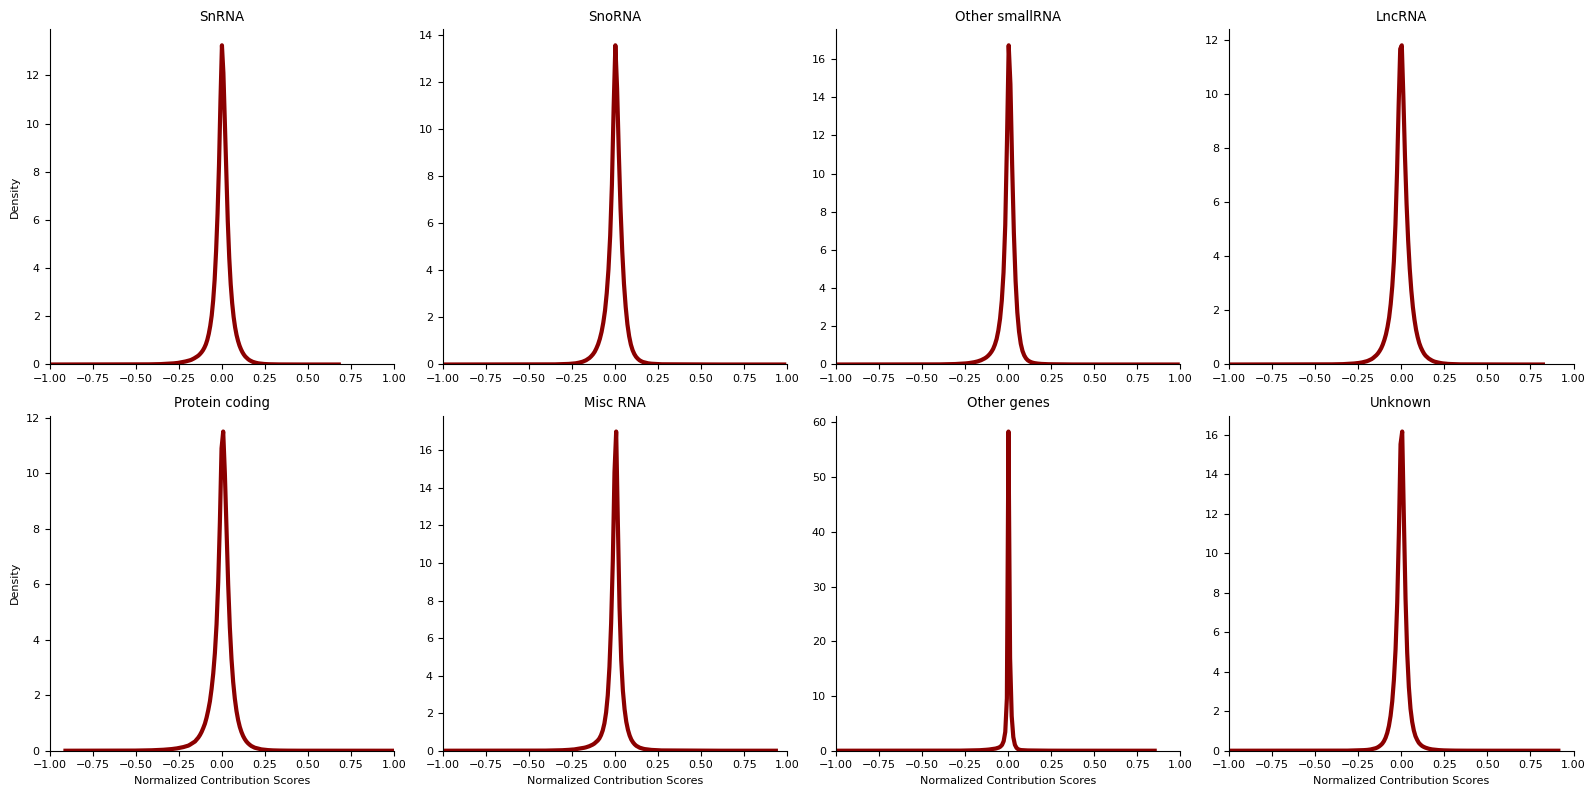

In [58]:
trans_rna_cols = [1,2,0,4,5,3,6,7]
trans_rna_types = ['SnRNA','SnoRNA','Other smallRNA','LncRNA','Protein coding','Misc RNA','Other genes','Unknown']
fig, ax = plt.subplots(2,4,figsize=(16, 8))
for l,k,rt in zip(range(8),trans_rna_cols,trans_rna_types):
    arr_data = trans_rna_score[:,:,k].flatten()/max(np.max(trans_rna_score[:,:,k].flatten()),-np.min(trans_rna_score[:,:,k].flatten()))
    ridx=l//4
    cidx=l%4
    sns.distplot(a=arr_data, hist = False, kde = True,kde_kws = {'linewidth': 3}, label = rt, color='darkred', ax=ax[ridx,cidx])
    ax[ridx,cidx].set_title(rt)
    ax[ridx,cidx].set_xlim(-1,1)
    if(cidx==0):
        ax[ridx,cidx].set_ylabel('Density')
    else:
        ax[ridx,cidx].set_ylabel('')
    if(ridx==1):
        ax[ridx,cidx].set_xlabel('Normalized Contribution Scores')
    else:
        ax[ridx,cidx].set_xlabel('')
        
plt.tight_layout()
#plt.savefig(f'{plot_dir}/HFF_Trans_RNA_Contribution_Score_Density_Plot_Individuals.pdf')


### Supplementary Fig. 12: Correlations between model inputs and absoulte contribution scores of trans-located caRNAs

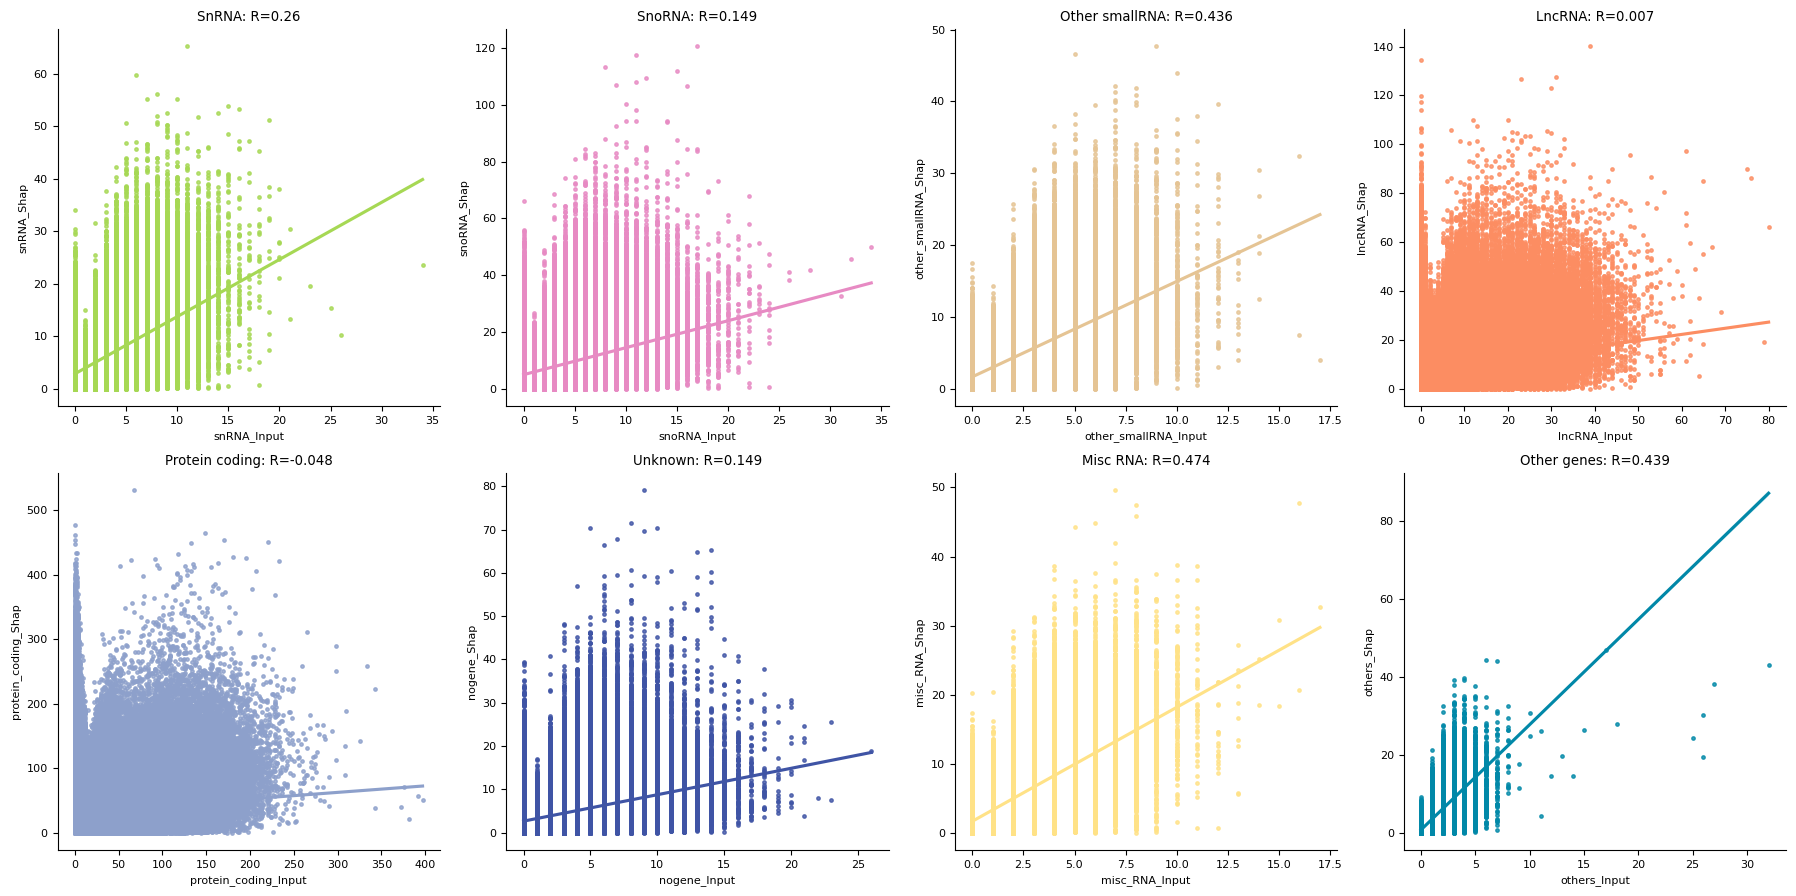

In [59]:
all_input_score = pd.read_table(f'{data_dir}/Model_interpretation/Seq+Trans-locatedRNA/All_bins_RNA_Input_Contribution_Scores_annos.txt',header=0,sep='\t')

fig,ax=plt.subplots(2,4,figsize=(18,9))
RNA_type = ['snRNA','snoRNA','other_smallRNA','lncRNA','protein_coding','nogene','misc_RNA','others']
title_name = ['SnRNA','SnoRNA','Other smallRNA','LncRNA','Protein coding','Unknown','Misc RNA','Other genes']
palette_set2 = sns.color_palette("Set2", 8)
colors =[palette_set2[4],palette_set2[3],palette_set2[6],palette_set2[1],palette_set2[2],'#3F54A5','#FFE287','#0188A8']

for i, rt, tn, color in zip(range(8),RNA_type,title_name,colors):
    ridx = i//4
    cidx = i%4
    all_input_score[f'{rt}_Shap'] = all_input_score[f'{rt}_Shap'].abs()
    corrs = round(spearmanr(all_input_score[f'{rt}_Input'], all_input_score[f'{rt}_Shap'])[0],3)
    sns.regplot(x=f'{rt}_Input',y=f'{rt}_Shap',data=all_input_score,ax=ax[ridx,cidx],scatter_kws={'s':6},color=color)
    ax[ridx,cidx].set_title(f"{tn}: R={corrs}")
plt.tight_layout()
#plt.savefig(f'{plot_dir}/HFF_Trans_RNA_Feature_Input_Importance_Score_Correlation.png',dpi=300)
    

### Supplementary Fig. 13: Simulation showing the contribution of trans-located caRNAs at TAD boundaries

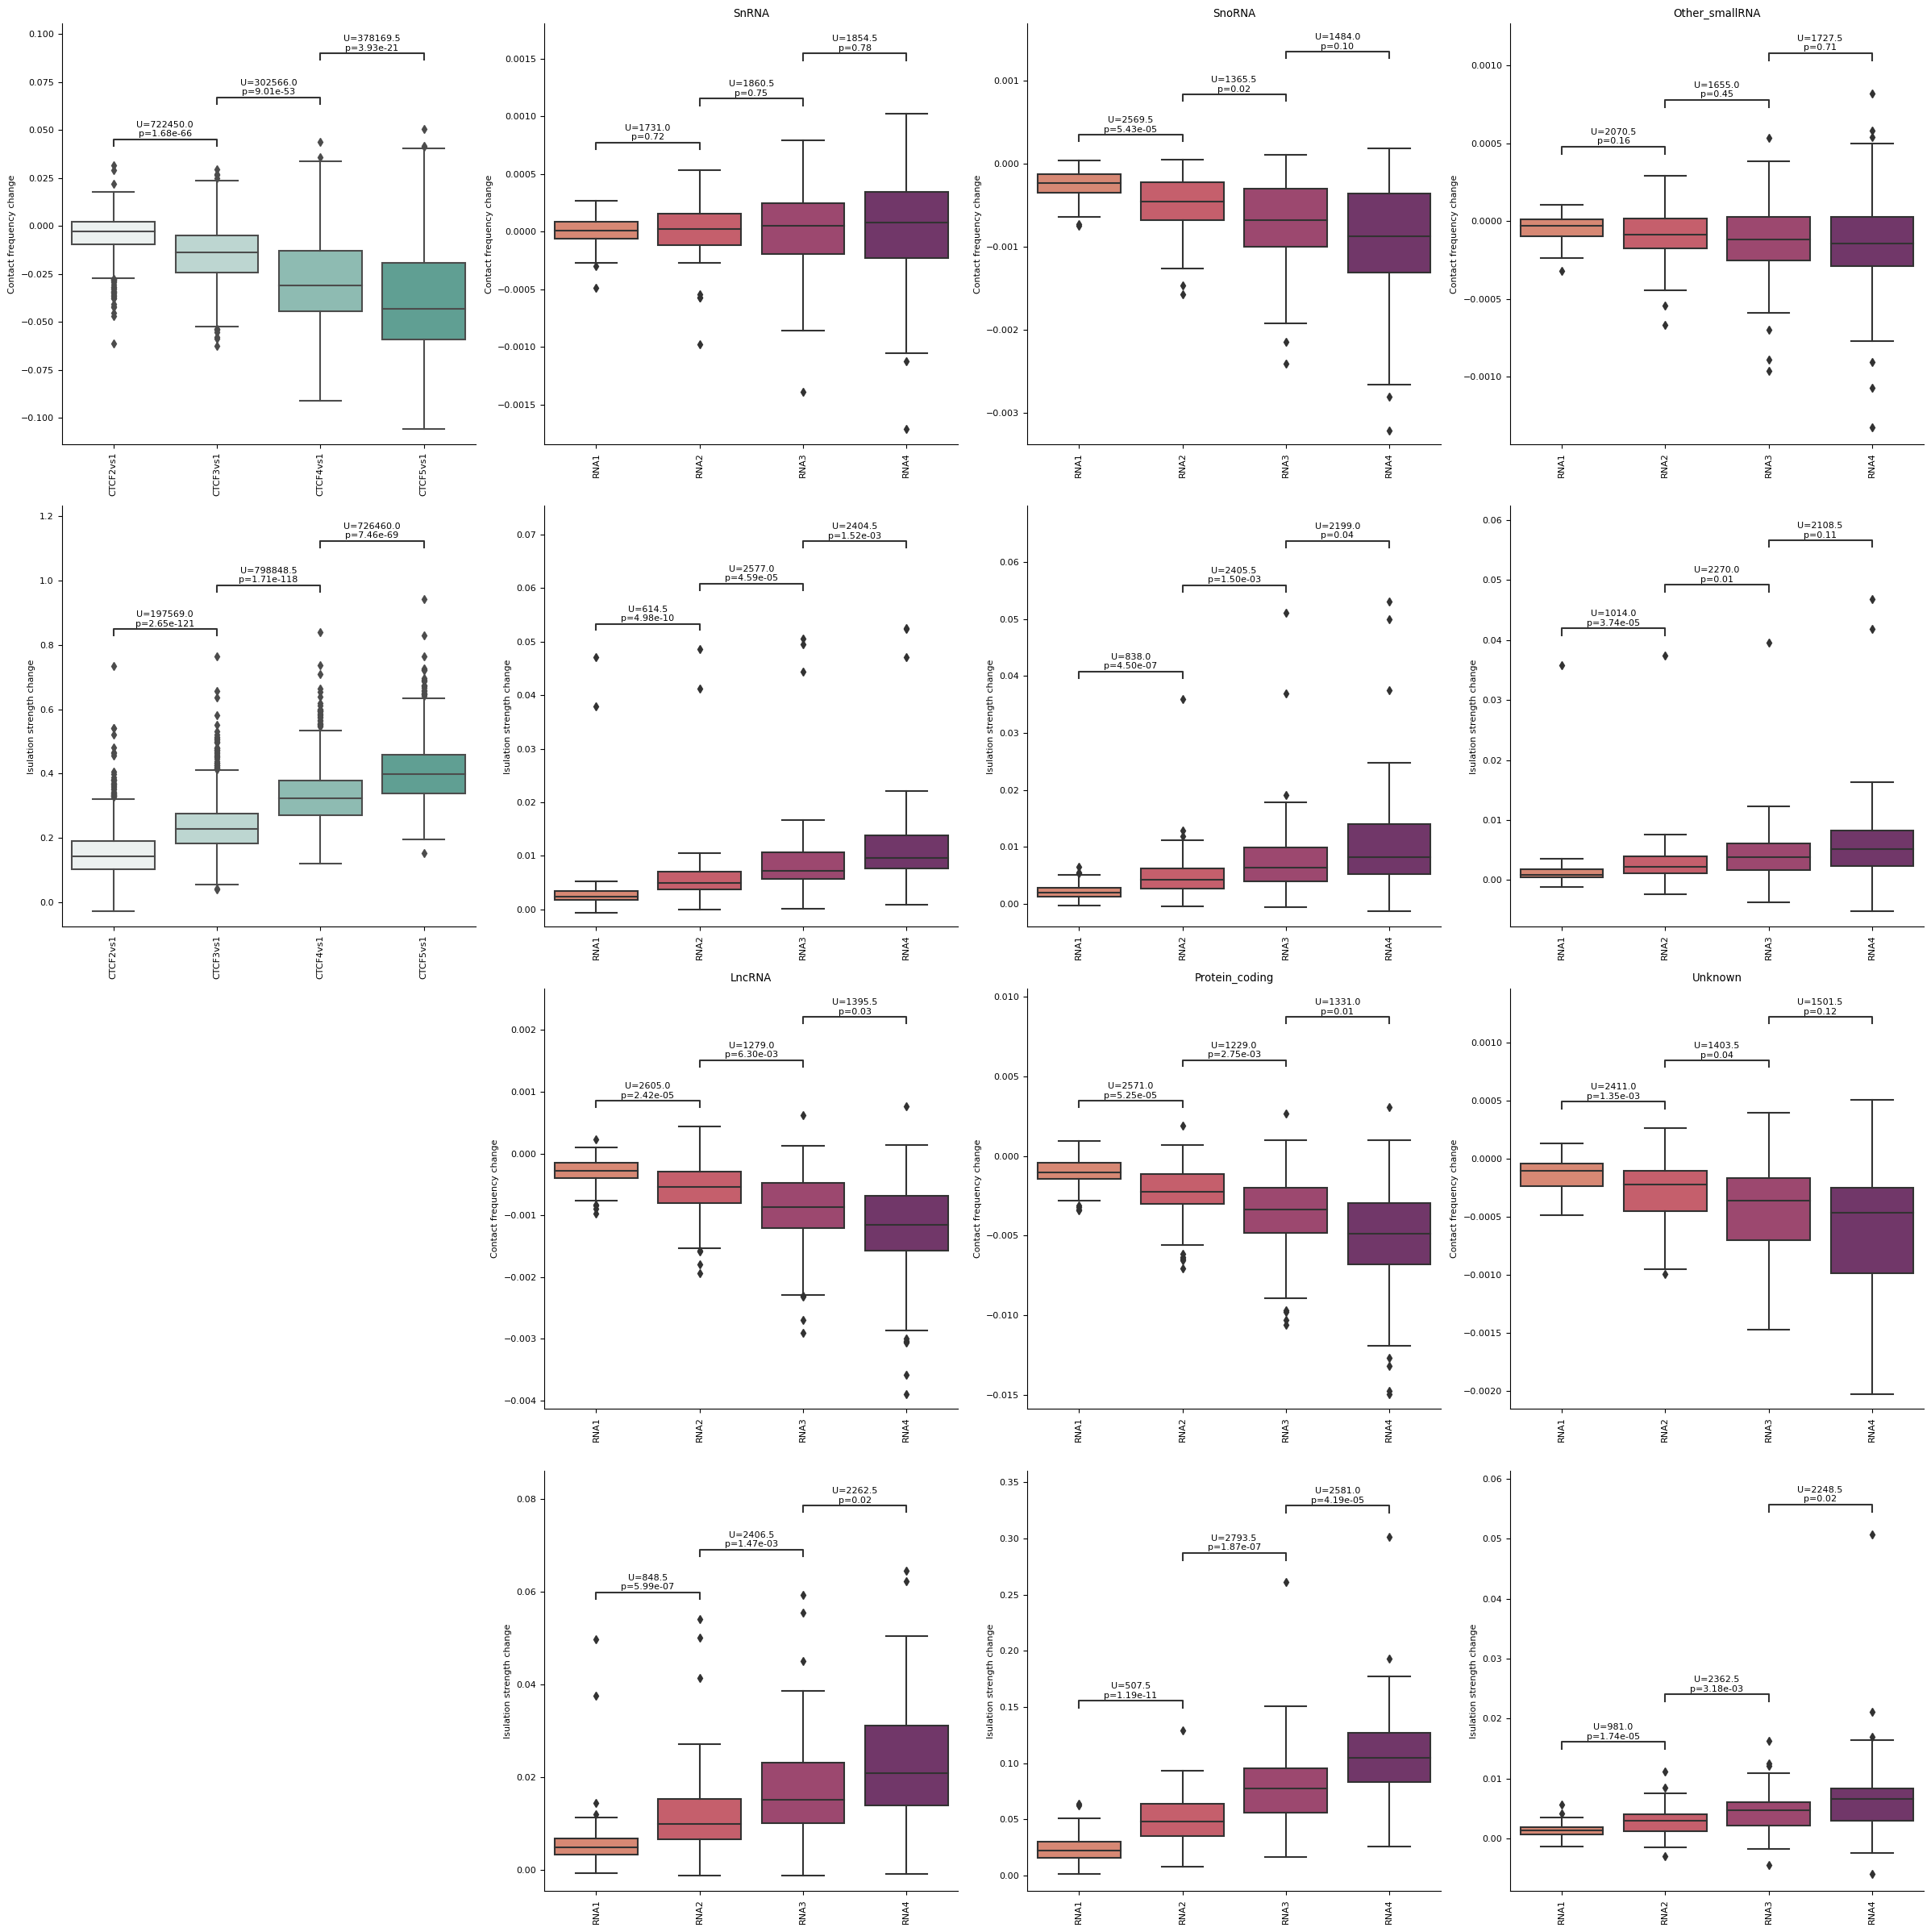

In [60]:
def plot_TAD_change(df,comp_pairs,colors,ax,ylabel,name=None):
    sns.boxplot(x="variable", y="value", data=pd.melt(df),ax=ax,palette=colors)
    custom_anno = []
    for cp in comp_pairs:
        U,p = mannwhitneyu(df[cp[0]].values, df[cp[1]].values)
        if(p<0.01):
            custom_anno.append(f"U={U}\np={p:.2e}")
        else:
            custom_anno.append(f"U={U}\np={p:.2f}")
    add_stat_annotation(ax,data=pd.melt(df), x="variable", y="value",box_pairs=comp_pairs,
                    text_annot_custom=custom_anno, test='Mann-Whitney', loc='inside', verbose=0)
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    if(name):
        ax.set_title(name)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

map_diff_CTCF = pd.read_table(f'{data_dir}/Simulation/TAD_strength_increase_simulations_mapdiff_CTCF.csv',sep='\t',header=0,index_col=0)
tad_diff_CTCF = pd.read_table(f'{data_dir}/Simulation/TAD_strength_increase_simulations_tad_diff_CTCF.csv',sep='\t',header=0,index_col=0)
pair_names_CTCF = [('CTCF2vs1','CTCF3vs1'),('CTCF4vs1','CTCF3vs1'),('CTCF5vs1','CTCF4vs1')]
color_palette_CTCF = sns.color_palette("light:#5A9", n_colors=4)
color_palette_RNA = sns.color_palette("flare", n_colors=4)

fig, ax = plt.subplots(4,4,figsize=(24, 24))

plot_TAD_change(map_diff_CTCF,pair_names_CTCF,color_palette_CTCF,ax[0,0],'Contact frequency change')
plot_TAD_change(tad_diff_CTCF,pair_names_CTCF,color_palette_CTCF,ax[1,0],'Isulation strength change') 
ax[2,0].set_axis_off()
ax[3,0].set_axis_off()

RNA_types = ['SnRNA', 'SnoRNA', 'Other_smallRNA', 'LncRNA', 'Protein_coding', 'Unknown']
pair_names_RNA = [('RNA1','RNA2'),('RNA3','RNA2'),('RNA4','RNA3')]
for (i,rt) in enumerate(RNA_types):
    map_diff_RNA = pd.read_table(f'{data_dir}/Simulation/TAD_strength_increase_simulations_mapdiff_{rt}.csv',sep='\t',header=0,index_col=0)
    tad_diff_RNA = pd.read_table(f'{data_dir}/Simulation/TAD_strength_increase_simulations_tad_diff_{rt}.csv',sep='\t',header=0,index_col=0)
    if(i<3):
        j = i//3
        k = i%3+1
    else:
        j = (i-3)//3+2
        k = (i-3)%3+1
    plot_TAD_change(map_diff_RNA,pair_names_RNA,color_palette_RNA,ax[j,k],'Contact frequency change',name=rt)
    plot_TAD_change(tad_diff_RNA,pair_names_RNA,color_palette_RNA,ax[j+1,k],'Isulation strength change')

plt.tight_layout()
#plt.savefig(f'{plot_dir}/TAD_change_trends_simulation.pdf')

### Supplementary Fig. 14: The enrichment of regions with high contribution at TAD boundaries, loop anchors, SPIN and chromHMM states - additional data

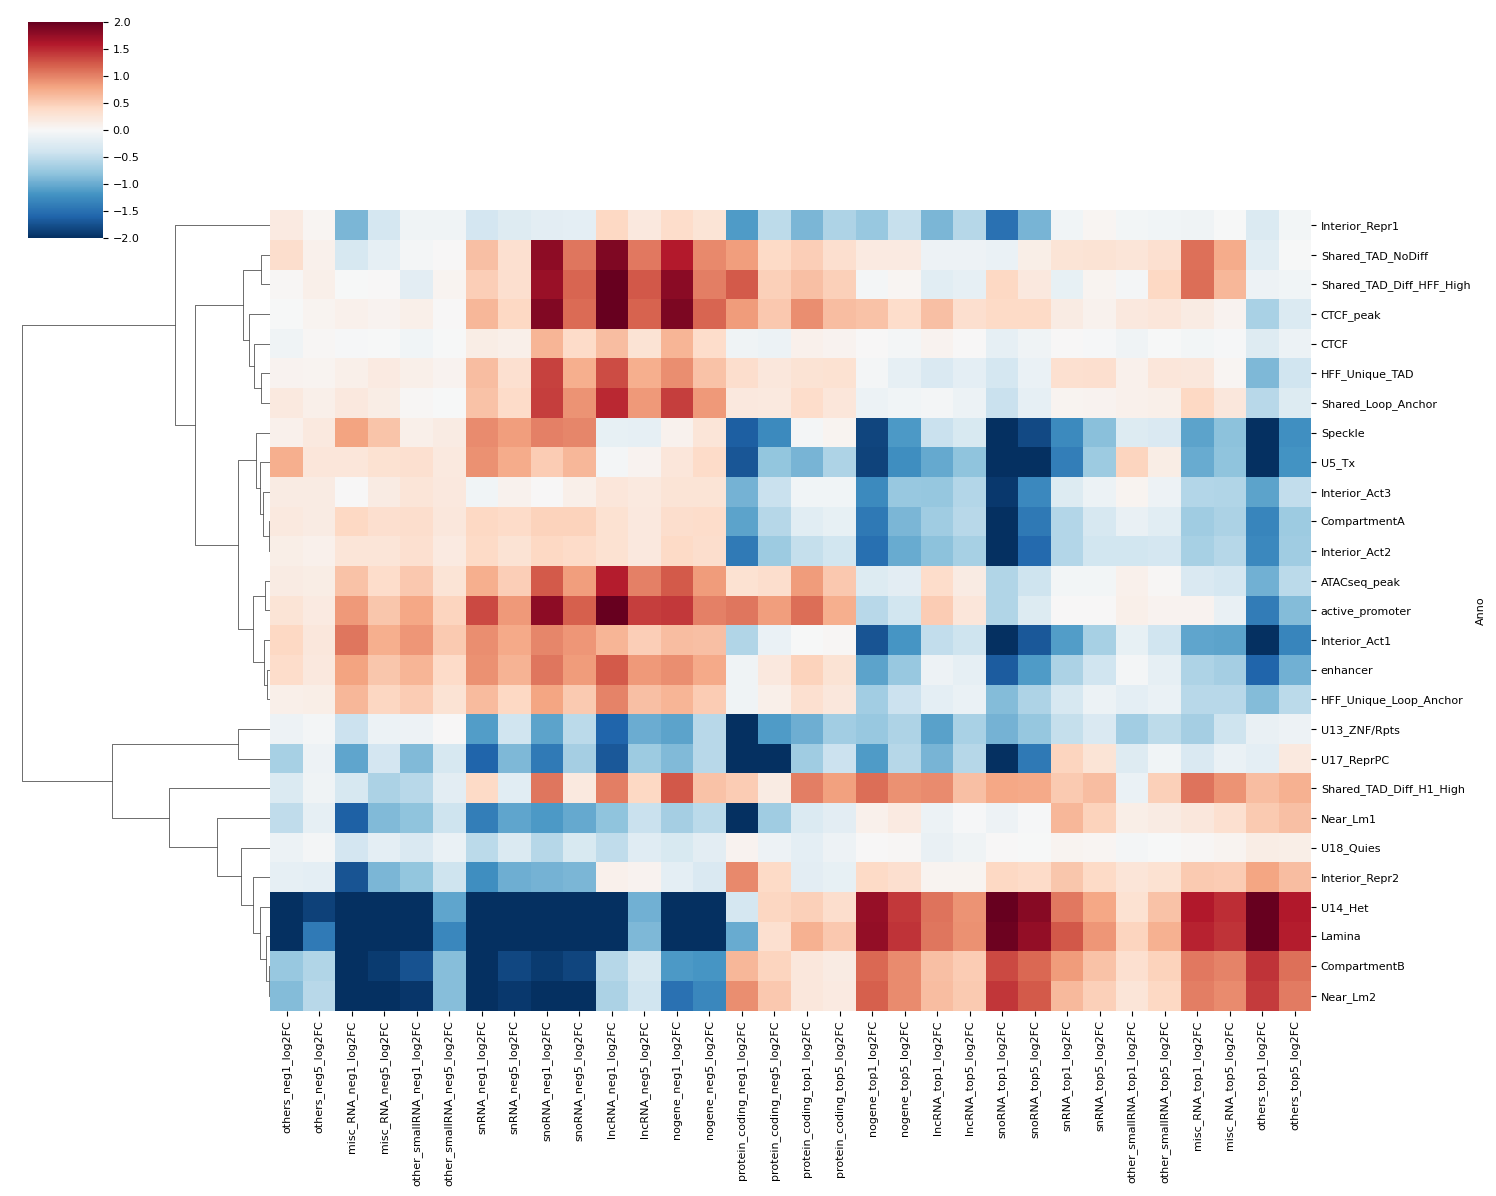

In [61]:
rna_df_keys = ['top1','top5','neg1','neg5','all']
rna_labels_all = ['snRNA','snoRNA','other_smallRNA','lncRNA','protein_coding','nogene','misc_RNA','others']
data_dir_sub = f'{data_dir}/Model_interpretation/Seq+Trans-locatedRNA'
trans_rna_all_FC_log2 = get_FC_df(rna_labels_all,rna_df_keys,trans_RNA_values,bin_annos,data_dir_sub) 

trans_rna_all_FC_log2 = trans_rna_all_FC_log2[['others_neg1_log2FC','others_neg5_log2FC','misc_RNA_neg1_log2FC','misc_RNA_neg5_log2FC', \
                                     'other_smallRNA_neg1_log2FC','other_smallRNA_neg5_log2FC','snRNA_neg1_log2FC','snRNA_neg5_log2FC', \
                                     'snoRNA_neg1_log2FC','snoRNA_neg5_log2FC','lncRNA_neg1_log2FC','lncRNA_neg5_log2FC', \
                                     'nogene_neg1_log2FC','nogene_neg5_log2FC','protein_coding_neg1_log2FC','protein_coding_neg5_log2FC', \
                                     'protein_coding_top1_log2FC','protein_coding_top5_log2FC','nogene_top1_log2FC','nogene_top5_log2FC', \
                                     'lncRNA_top1_log2FC','lncRNA_top5_log2FC','snoRNA_top1_log2FC','snoRNA_top5_log2FC', \
                                     'snRNA_top1_log2FC','snRNA_top5_log2FC','other_smallRNA_top1_log2FC','other_smallRNA_top5_log2FC', 
                                    'misc_RNA_top1_log2FC','misc_RNA_top5_log2FC','others_top1_log2FC','others_top5_log2FC']]

g= sns.clustermap(trans_rna_all_FC_log2,cmap='RdBu_r',col_cluster=False,yticklabels=True,xticklabels=True,figsize=(15,12),vmin=-2,vmax=2,metric="correlation",method='average')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(),fontsize=8)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8)
plt.show()
#plt.savefig(f'{plot_dir}/RNAType_Selected_1_5_per_Bins_Enrichment_plot.pdf')  


### Supplementary Fig. 15: The enrichment of regions with high contribution from ATAC-seq at active chromatin

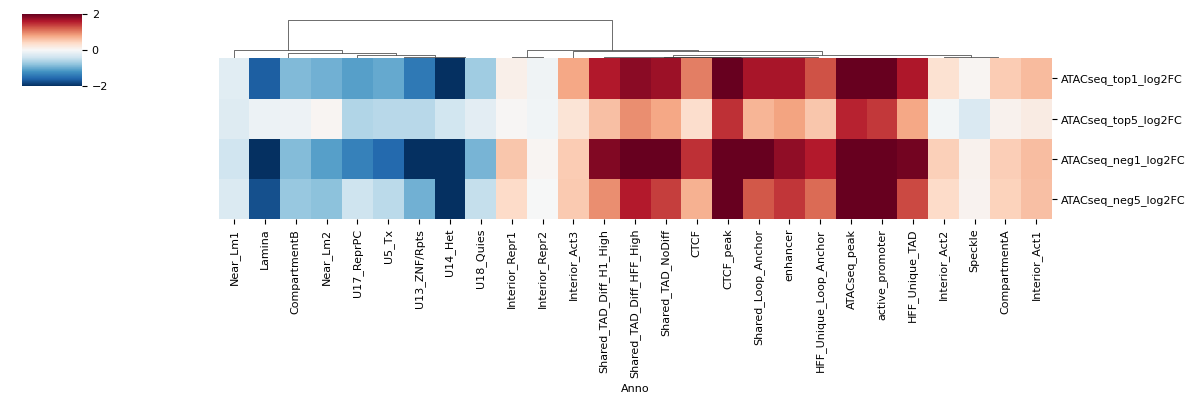

In [62]:
atac_label = ['ATACseq']
data_dir_sub = f'{data_dir}/Model_interpretation/Seq+Trans-locatedRNA'
atac_values = pd.read_table(f'{data_dir}/Genomic_bin_data/HFFc6_ATACseq_2048.bedgraph',header=0,sep='\t')
atac_values.columns = ['chrom','start','end','ATACseq']
atac_dir_sub = f'{data_dir}/Model_interpretation/Seq+ATAC-seq'
atac_FC_log2 = get_FC_df(atac_label,rna_df_keys,atac_values,bin_annos,atac_dir_sub) 

g = sns.clustermap(atac_FC_log2.T,cmap='RdBu_r',row_cluster=False,yticklabels=True,xticklabels=True,figsize=(12,4),vmin=-2,vmax=2,metric="correlation",method='average')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(),fontsize=8)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8)
plt.show()
#plt.savefig(f'{plot_dir}/ATACseq_Selected_1_5_per_Bins_Enrichment_plot.pdf')  


### Supplementary Fig. 16: The enrichment of regions with higher contribution scores of trans-located caRNAs compared to chromatin accessibility at TAD boundaries, loop anchors and nuclear structures

In [63]:
def get_diff_sites(arr,arr2,i,label):
    array1 = arr[:,:,i].flatten()/max(np.max(arr[:,:,i].flatten()),-np.min(arr[:,:,i].flatten()))
    array2 = arr2[:,:,0].flatten()/max(np.max(arr2[:,:,0].flatten()),-np.min(arr2[:,:,0].flatten()))
    df = pd.DataFrame(np.vstack((array1,array2)).T,columns=[label,'ATACseq'])
    df_sub1 = df[(((df[label]/df['ATACseq'])>5)|((df[label]/df['ATACseq'])<-5)) & (df[label].abs()>0.25)]
    df_sub2 = df[(((df['ATACseq']/df[label])>5)|((df['ATACseq']/df[label])<-5)) & (df['ATACseq'].abs()>0.25)]
    df_sub1['seq'] = df_sub1.index//512
    df_sub1['loc'] = df_sub1.index%512
    df_sub2['seq'] = df_sub2.index//512
    df_sub2['loc'] = df_sub2.index%512
    return df_sub1, df_sub2

def label_diff_sites(arr,arr2,i,label,colors=("red", "grey", "green")):
    array1 = arr[:,:,i].flatten()/max(np.max(arr[:,:,i].flatten()),-np.min(arr[:,:,i].flatten()))
    array2 = arr2[:,:,0].flatten()/max(np.max(arr2[:,:,0].flatten()),-np.min(arr2[:,:,0].flatten()))
    df = pd.DataFrame(np.vstack((array1,array2)).T,columns=[label,'ATACseq'])
    df.loc[(((df[label]/df['ATACseq'])>5)|((df[label]/df['ATACseq'])<-5)) & (df[label].abs()>0.25),'color'] = colors[0]
    df.loc[(((df['ATACseq']/df[label])>5)|((df['ATACseq']/df[label])<-5)) & (df['ATACseq'].abs()>0.25),'color'] = colors[2]
    df['color'].fillna(colors[1], inplace=True)
    df['seq'] = df.index//512
    df['loc'] = df.index%512
    return df

def get_unique_bins(df,label):
    unique_coords = []
    bin_dict ={}
    unique_df = pd.DataFrame(columns=['Index']+list(df.columns.values))
    for row in df.itertuples():
        #print(row)
        bin_loc = row.chrom+"_"+str(row.start)+"_"+str(row.end)
        if bin_loc not in unique_coords:
            unique_coords.append(bin_loc)
        if bin_loc in bin_dict:
            if(abs(getattr(row,label))>abs(getattr(bin_dict[bin_loc],label))):
                bin_dict[bin_loc] = row
        else:
            bin_dict[bin_loc] = row
    for i,unqiue_coord in enumerate(unique_coords):
        unique_df.loc[i] = bin_dict[unqiue_coord]
    return unique_df

def get_value_count(df_filter,df1_filter,label,subname):
    df1_count = []
    df_count = []
    count_name_orders = ['CTCF','CTCF_peak','ATACseq_peak','active_promoter','enhancer']
    chromHMM_order=['U5_Tx','U13_ZNF/Rpts', 'U14_Het', 'U17_ReprPC', 'U18_Quies']
    SPIN_order = ['Speckle', 'Interior_Act1', 'Interior_Act2', 'Interior_Act3', 'Interior_Repr1', 'Interior_Repr2', 'Near_Lm1', 'Near_Lm2', 'Lamina']
    TAD_order = ['Shared_TAD_NoDiff','Shared_TAD_Diff_H1_High','Shared_TAD_Diff_HFF_High','HFF_Unique_TAD']
    loop_order = ['Shared_Loop_Anchor','HFF_Unique_Loop_Anchor']
    compartment_order = ['CompartmentA','CompartmentB']
    name_orders = count_name_orders+chromHMM_order+compartment_order+TAD_order+loop_order+SPIN_order
    for cname in count_name_orders:
        df1_count.append(df1_filter[df1_filter[cname]>0].shape[0])
        df_count.append(df_filter[df_filter[cname]>0].shape[0])
    df1_count += df1_filter['chromHMM'].value_counts().reindex(chromHMM_order).to_list()
    df_count += df_filter['chromHMM'].value_counts().reindex(chromHMM_order).to_list()
    df1_count += df1_filter['compartment'].value_counts().reindex(compartment_order).to_list()
    df_count += df_filter['compartment'].value_counts().reindex(compartment_order).to_list()
    df1_count += df1_filter['TAD'].value_counts().reindex(TAD_order).to_list()
    df_count += df_filter['TAD'].value_counts().reindex(TAD_order).to_list()
    df1_count += df1_filter['loop'].value_counts().reindex(loop_order).to_list()
    df_count += df_filter['loop'].value_counts().reindex(loop_order).to_list()
    df1_count += df1_filter['SPIN'].value_counts().reindex(SPIN_order).to_list()
    df_count += df_filter['SPIN'].value_counts().reindex(SPIN_order).to_list()
    result_df = pd.DataFrame({'Anno':name_orders,label+'_'+subname:df1_count,label+'_all':df_count})
    result_df[f'{label}_FC'] = (result_df[f'{label}_{subname}']/df1_filter.shape[0])/(result_df[f'{label}_all']/df_filter.shape[0])
    return result_df
    

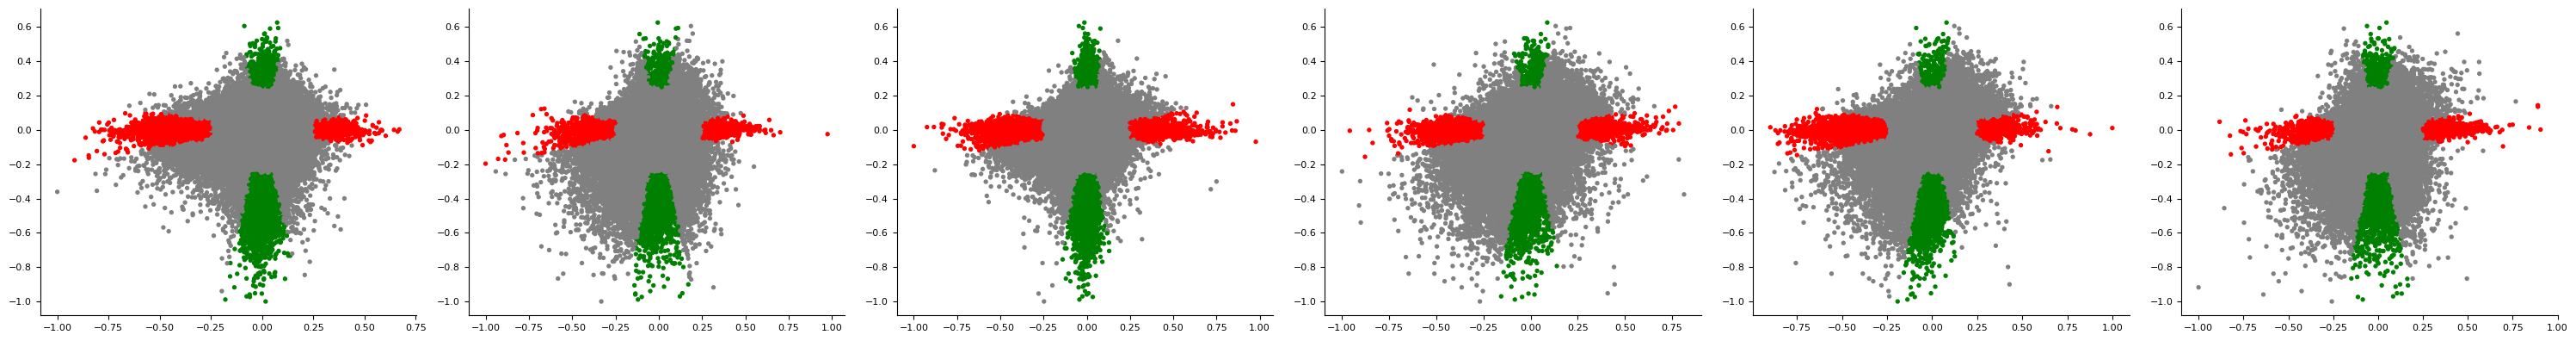

In [64]:
atac_score_files = ['train_atac_scores.h5','valid_atac_scores.h5','test_atac_scores.h5']
for i, sf in enumerate(atac_score_files):
    if(i==0):
        atac_score = h5py.File(f'{data_dir}/Best_models/Feature_inputs_and_contribution_scores/Seq+ATAC-seq/{sf}','r')['rna_contrib_scores'][:,:,:]
    else:
        atac_score = np.concatenate((atac_score,h5py.File(f'{data_dir}/Best_models/Feature_inputs_and_contribution_scores/Seq+ATAC-seq/{sf}','r')['rna_contrib_scores'][:,:,:]),axis=0)

rna_indexes = [1,2,0,4,5,7]
rna_labels = ['snRNA','snoRNA','other_smallRNA','lncRNA','protein_coding','nogene']
fig, axes = plt.subplots(1,6,figsize=(30,4))
mycolors = ("red", "grey", "green")
for i,j,label in zip(rna_indexes,range(6),rna_labels):
    sub_df = label_diff_sites(trans_rna_score,atac_score,i,label)
    assign_values = {col: k for k, col in enumerate(mycolors)}
    color_num = [assign_values[k] for k in sub_df['color']]
    axes[j].scatter(sub_df[label], sub_df['ATACseq'], c=color_num, cmap=ListedColormap(mycolors), alpha=1,
                            s=8, marker="o")
plt.tight_layout()
#plt.savefig(f'{plot_dir}/RNA_ATAC_Normalized_Importance_Score_Comparison.png')

In [65]:
locinfos = pd.read_table(f'{data_dir}/Genomic_bin_data/sequence_bins_inorder',sep='\t',header=0)
locinfos.rename(columns = {'index':'seq'}, inplace = True)
diff_df_high = {}
diff_df_low = {}
for i,j,label in zip(rna_indexes,range(6),rna_labels):
    diff_df_high[label],diff_df_low[label] = get_diff_sites(trans_rna_score,atac_score,i,label)
    
diff_df_high_annos = {}
diff_df_low_annos = {}
for rna_label in rna_labels:
    df_sub_h = diff_df_high[rna_label].merge(locinfos,on=['seq','loc'])
    df_sub_h_u = get_unique_bins(df_sub_h,rna_label)
    df_sub_h_u.drop(['Index'],axis=1,inplace=True)
    df_sub_h_u.rename(columns={rna_label:rna_label+'_shap','ATACseq':'ATACseq_shap'},inplace=True)
    diff_df_high_annos[rna_label] = df_sub_h_u.merge(trans_RNA_values,on=['chrom','start','end']).merge(bin_annos,on=['chrom','start','end'])
    df_sub_l = diff_df_low[rna_label].merge(locinfos,on=['seq','loc'])
    df_sub_l_u = get_unique_bins(df_sub_l,'ATACseq')
    df_sub_l_u.drop(['Index'],axis=1,inplace=True)
    df_sub_l_u.rename(columns={rna_label:rna_label+'_shap','ATACseq':'ATACseq_shap'},inplace=True)
    diff_df_low_annos[rna_label] = df_sub_l_u.merge(trans_RNA_values,on=['chrom','start','end']).merge(bin_annos,on=['chrom','start','end'])

for rna_label in rna_labels:
    diff_df_high_annos[rna_label]['bin_id'] = diff_df_high_annos[rna_label]['chrom']+"_"+diff_df_high_annos[rna_label]['start'].astype(str)+"_"+diff_df_high_annos[rna_label]['end'].astype(str)
    diff_df_low_annos[rna_label]['bin_id'] = diff_df_low_annos[rna_label]['chrom']+"_"+diff_df_low_annos[rna_label]['start'].astype(str)+"_"+diff_df_low_annos[rna_label]['end'].astype(str)

    
### High(red) vs grey (Positive)
FC_diff_high_annos_top_grey = {}
FC_df_high_top_grey = pd.DataFrame()
bin_annos_trans_RNA = bin_annos.merge(trans_RNA_values,on=['chrom','start','end'])
bin_annos_trans_RNA['bin_id'] = bin_annos_trans_RNA['chrom']+"_"+bin_annos_trans_RNA['start'].astype(str)+"_"+bin_annos_trans_RNA['end'].astype(str)
for rna_label in rna_labels:
    background_df_1 = bin_annos_trans_RNA[~bin_annos_trans_RNA.bin_id.isin(diff_df_high_annos[rna_label].bin_id)]
    background_df = background_df_1[~background_df_1.bin_id.isin(diff_df_low_annos[rna_label].bin_id)]
    FC_diff_high_annos_top_grey[rna_label] = get_value_count(background_df[background_df[rna_label]>0],diff_df_high_annos[rna_label][(diff_df_high_annos[rna_label][rna_label]>0) & (diff_df_high_annos[rna_label][f'{rna_label}_shap']>0)],rna_label,'high').set_index('Anno')
    FC_df_high_top_grey = pd.concat([FC_df_high_top_grey, FC_diff_high_annos_top_grey[rna_label]],axis=1)

rna_labels_log2 = []
for rna_label in rna_labels:
    FC_df_high_top_grey[f'{rna_label}_top_log2FC'] = np.log2(FC_df_high_top_grey[f'{rna_label}_FC'])
    rna_labels_log2.append(f'{rna_label}_top_log2FC')

FC_df_high_top_log2_grey = FC_df_high_top_grey[rna_labels_log2] 

### High(red) vs grey (Negative)
FC_diff_high_annos_neg_grey = {}
FC_df_high_neg_grey = pd.DataFrame()
for rna_label in rna_labels:
    background_df_1 = bin_annos_trans_RNA[~bin_annos_trans_RNA.bin_id.isin(diff_df_high_annos[rna_label].bin_id)]
    background_df = background_df_1[~background_df_1.bin_id.isin(diff_df_low_annos[rna_label].bin_id)]
    FC_diff_high_annos_neg_grey[rna_label] = get_value_count(background_df[background_df[rna_label]>0],diff_df_high_annos[rna_label][(diff_df_high_annos[rna_label][rna_label]>0) & (diff_df_high_annos[rna_label][f'{rna_label}_shap']<0)],rna_label,'high').set_index('Anno')
    FC_df_high_neg_grey = pd.concat([FC_df_high_neg_grey, FC_diff_high_annos_neg_grey[rna_label]],axis=1)

rna_labels_log2 = []
for rna_label in rna_labels:
    FC_df_high_neg_grey[f'{rna_label}_neg_log2FC'] = np.log2(FC_df_high_neg_grey[f'{rna_label}_FC'])
    rna_labels_log2.append(f'{rna_label}_neg_log2FC')

FC_df_high_neg_log2_grey = FC_df_high_neg_grey[rna_labels_log2]
FC_df_high_top_neg_log2_grey = pd.concat([FC_df_high_top_log2_grey,FC_df_high_neg_log2_grey],axis=1)


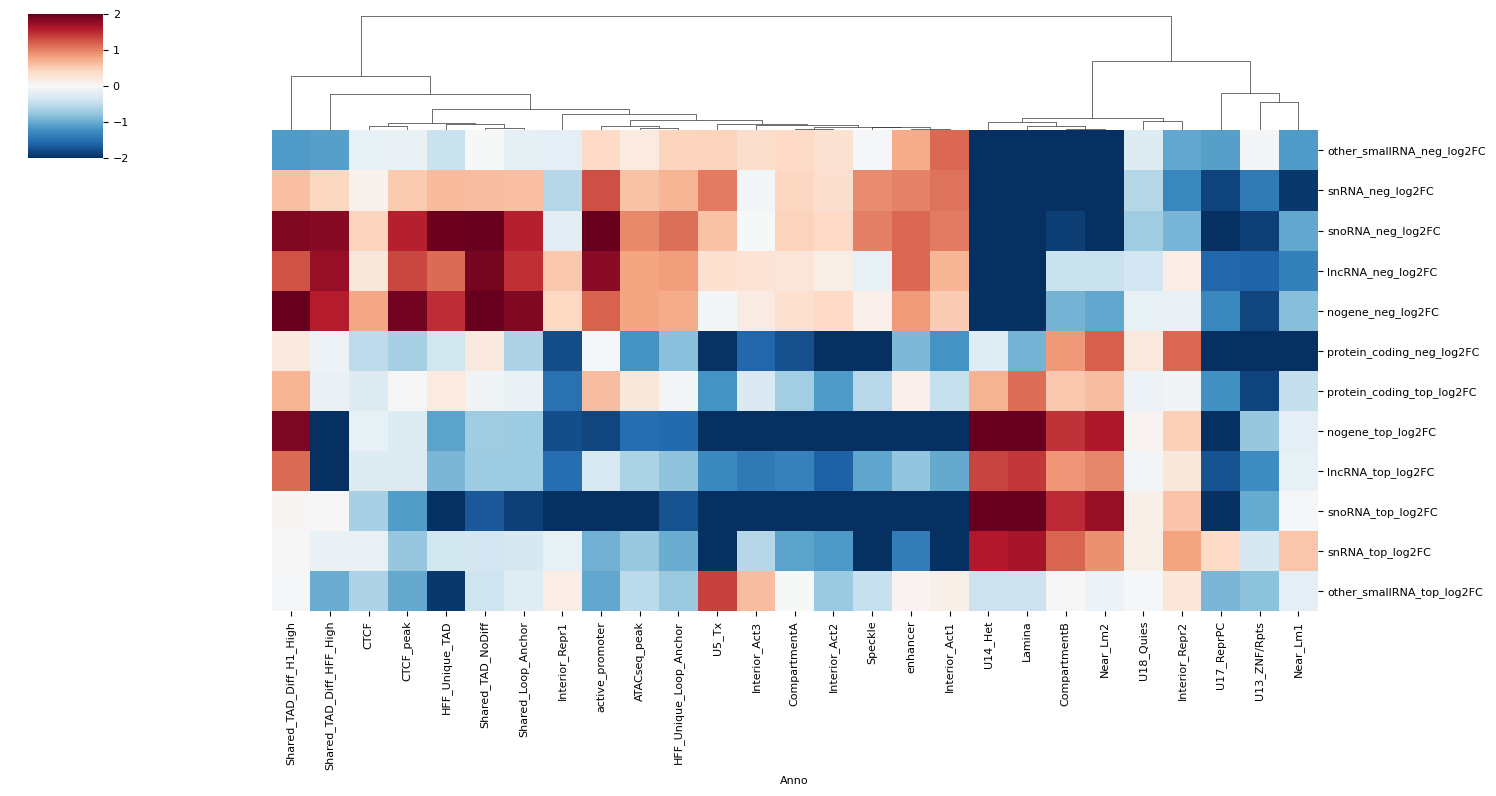

In [66]:
FC_df_high_top_neg_log2_grey = FC_df_high_top_neg_log2_grey.fillna(0)
FC_df_high_top_neg_log2_grey_reorder = FC_df_high_top_neg_log2_grey[['other_smallRNA_neg_log2FC','snRNA_neg_log2FC','snoRNA_neg_log2FC','lncRNA_neg_log2FC','nogene_neg_log2FC','protein_coding_neg_log2FC','protein_coding_top_log2FC','nogene_top_log2FC','lncRNA_top_log2FC','snoRNA_top_log2FC','snRNA_top_log2FC','other_smallRNA_top_log2FC']]

g = sns.clustermap(FC_df_high_top_neg_log2_grey_reorder.T,cmap='RdBu_r',row_cluster=False,yticklabels=True,xticklabels=True,figsize=(15,8),vmin=-2,vmax=2,metric="correlation",method='average')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(),fontsize=8)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8)
plt.show()
#plt.savefig(f'{plot_dir}/Bins_Higher_TransRNA_IS_Scores_Enrichment_vs_grey_region_plot_combined.pdf') 

### Supplementary Fig. 17: Nascent expression of RNAs preferentially locate at genomic regions with large absolute contribution scores

In [67]:
def get_RNAs_for_subset_rank(rnatypes,st,rna_values,rank,RNA_exp):
    result_df = pd.DataFrame()
    rna_df_dict = {}
    for rnatype,rna_value in zip(rnatypes,rna_values):
        df_norm_data = pd.DataFrame()
        df = pd.read_table(f'{data_dir}/Model_interpretation/Seq+Trans-locatedRNA/{rnatype}/RNAs_interacted_{rnatype}_{st}_important_bins_pos.txt',sep='\t',header=0)
        df_norm = df.merge(RNA_exp, on=['Geneinfo'])
        df_norm['bin_ratio_norm'] = (df_norm['bin_ratio']/df_norm['Length'])*1000
        if('miRNA' in rna_value):
            rna_value_info = rna_value.split('|')
            df_norm_data = pd.DataFrame()
            for rv in rna_value_info:
                r_norm_df = df_norm[df_norm['Geneinfo'].str.contains(rv)]
                df_norm_data = pd.concat([df_norm_data,r_norm_df])
        else:
            df_norm_data = df_norm[df_norm['Geneinfo'].str.contains(rna_value)]
    
        df_sub = df_norm_data.sort_values('bin_ratio_norm',ascending=False).iloc[:rank]
        rna_df_dict[rnatype] = df_sub
        result_df[rnatype] = df_sub.reset_index()['Geneinfo']
    
    return result_df, rna_df_dict

Text(0.5, 0, '')

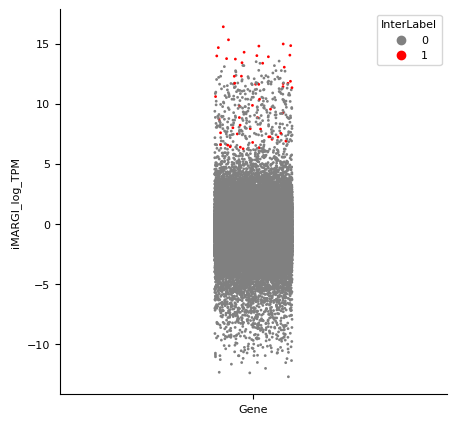

In [68]:
nascent = pd.read_table(f'{data_dir}/Data_exploration/HFFc6_iMARGI_nofilter1K_genelevel_TPM',sep='\t',header=0)
nascent['Geneinfo'] = nascent['Ensembl_ID']+"|"+nascent['GeneName']+"|"+nascent['GeneType']+"|"+nascent['GeneLoc']
rna_labels = ['snRNA','snoRNA','lncRNA','protein_coding','other_smallRNA']
rna_values = ['snRNA','snoRNA','lncRNA','protein_coding','scRNA|miRNA|sRNA|vault_RNA|ribozyme']
RNA_list_dict ={}
RNA_df_dict ={}
RNA_list_dict['top5'], RNA_df_dict['top5'] = get_RNAs_for_subset_rank(rna_labels,'top5',rna_values,10,nascent)
RNA_list_dict['neg5'], RNA_df_dict['neg5'] = get_RNAs_for_subset_rank(rna_labels,'neg5',rna_values,10,nascent)

RNA_list_combined = RNA_list_dict['top5']['snRNA'].tolist() + RNA_list_dict['top5']['snoRNA'].tolist() + \
                    RNA_list_dict['top5']['lncRNA'].tolist() + RNA_list_dict['top5']['protein_coding'].tolist() + \
                    RNA_list_dict['top5']['other_smallRNA'].tolist() + RNA_list_dict['neg5']['snRNA'].tolist() + \
                    RNA_list_dict['neg5']['snoRNA'].tolist() + RNA_list_dict['neg5']['lncRNA'].tolist() + \
                    RNA_list_dict['neg5']['protein_coding'].tolist() + RNA_list_dict['neg5']['other_smallRNA'].tolist()

RNA_list_combined_unique = list(set(RNA_list_combined))

RNA_exp_sub = nascent[['Geneinfo','iMARGI_TPM']]
RNA_exp_sub['InterLabel'] = '0'
RNA_exp_sub.loc[RNA_exp_sub['Geneinfo'].isin(RNA_list_combined_unique),'InterLabel'] = '1'
RNA_exp_sub['Gene'] = 'Gene'
RNA_exp_sub['iMARGI_log_TPM'] = np.log2(RNA_exp_sub['iMARGI_TPM'])
fig, ax = plt.subplots(figsize=(5,5))
sns.stripplot(data=RNA_exp_sub, x="Gene", y="iMARGI_log_TPM", hue="InterLabel",palette=['grey','red'],marker='o', size=2,ax=ax)
ax.set_xlabel('')
#plt.savefig(f'{plot_dir}/Top10_Selected_RNA_TPM_value.pdf')

### Supplementary Fig. 18: Additional candidate RNAs that are preferentially associated with genomic regions with large absolute contribution scores

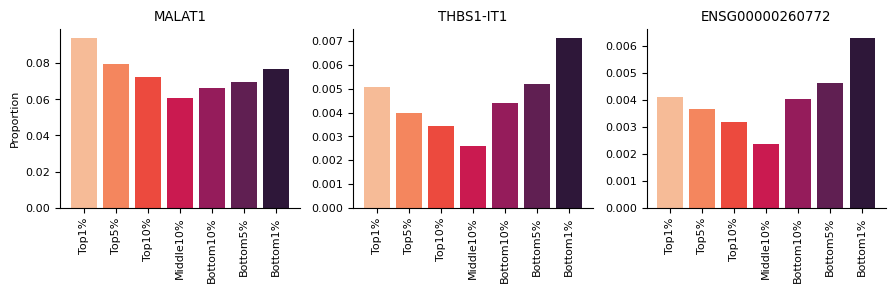

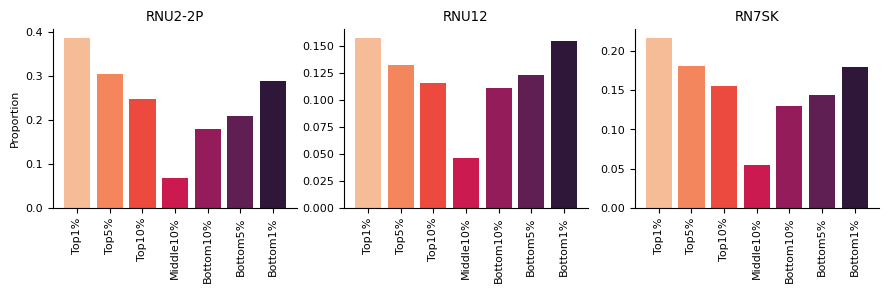

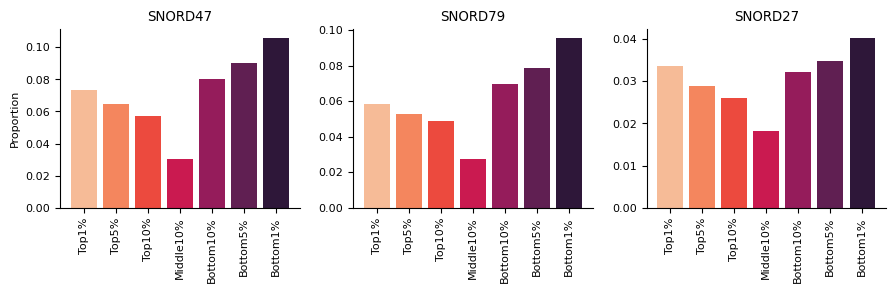

In [69]:
RNA_type = ['lncRNA','snRNA','snoRNA']
selected_RNAs = ['MALAT1|THBS1-IT1|ENSG00000260772','RNU2-2P|RNU12|RN7SK','SNORD47|SNORD79|SNORD27']
subsets = ['top1','top5','top10','mid10','neg10','neg5','neg1']
subset_names = ['Top1%','Top5%','Top10%','Middle10%','Bottom10%','Bottom5%','Bottom1%']
palette_r = sns.color_palette("rocket_r", 7)
reg_color = [palette_r[0],palette_r[1],palette_r[2],palette_r[3],palette_r[4],palette_r[5],palette_r[6]]
plot_RNA_genomic_region_interaction_ratio(RNA_type,selected_RNAs,subsets,subset_names,reg_color,'sup18')
    

### Supplementary Fig. 19: Candidate RNAs that are preferentially associated with genomic regions where trans-located caRNAs have large absolute contribution scores and ATAC-seq features do not

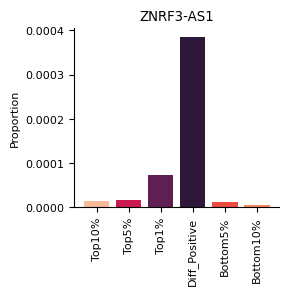

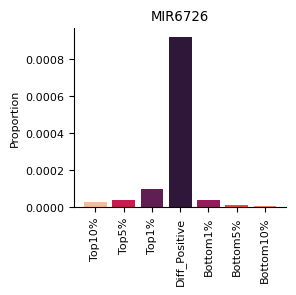

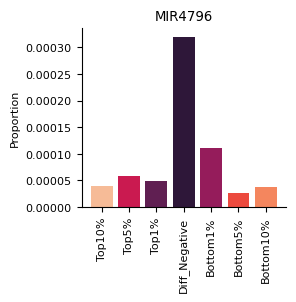

In [70]:
RNA_types = [['lncRNA'],['other_smallRNA'],['other_smallRNA']]
selected_RNAs_list = [['ZNRF3-AS1'],['MIR6726'], ['MIR4796']]
subset_list = [['top10','top5','top1','ATACseq_high_top','neg5','neg10'],
               ['top10','top5','top1','ATACseq_high_top','neg1','neg5','neg10'],
               ['top10','top5','top1','ATACseq_high_neg','neg1','neg5','neg10']]
subset_name_list = [['Top10%','Top5%','Top1%','Diff_Positive','Bottom5%','Bottom10%'],
                   ['Top10%','Top5%','Top1%','Diff_Positive','Bottom1%','Bottom5%','Bottom10%'],
                   ['Top10%','Top5%','Top1%','Diff_Negative','Bottom1%','Bottom5%','Bottom10%']]
color_list = [[palette_r[0],palette_r[3],palette_r[5],palette_r[6],palette_r[2],palette_r[1]],
             [palette_r[0],palette_r[3],palette_r[5],palette_r[6],palette_r[4],palette_r[2],palette_r[1]],
             [palette_r[0],palette_r[3],palette_r[5],palette_r[6],palette_r[4],palette_r[2],palette_r[1]]]

for (RNA_type,selected_RNAs,subsets,subset_names,reg_color) in zip(RNA_types,selected_RNAs_list,subset_list,subset_name_list,color_list):
    plot_RNA_genomic_region_interaction_ratio(RNA_type,selected_RNAs,subsets,subset_names,reg_color,'sup19')

